In [1]:
import scipy
import matplotlib
import numpy as np
import math
import pylab
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import colorbar
from matplotlib.patches import Ellipse
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterExponent
from matplotlib.ticker import LogLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FixedLocator
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from astropy.table import Table, vstack, join
from astropy.io import ascii, fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
from matplotlib.lines import Line2D
from matplotlib.path import Path
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
from astropy.stats import sigma_clip

In [2]:
def read_hsc(input_file_name):
   data = ascii.read(input_file_name,
        names=['id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr',
        'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n'])
   df = data.to_pandas()
   df['id'] = df['id'].astype(str)
   for column in df.columns:
      if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
         df[column] = df[column].str.decode('utf-8')
   df['g0'] = df['gpsf'] - df['a_g']
   df['i0'] = df['ipsf'] - df['a_i']
   df['n0'] = df['npsf'] - df['a_n']

   return df

In [3]:
## Read the whole HSC data
hsc_df1 = read_hsc('/emc1/home/jhong5/subaru_hsc/hsc_data/fornax_tpall3e_g24.cat') ; hsc_df1['name'] = 'for'
hsc_df2 = read_hsc('/emc1/home/jhong5/subaru_hsc/hsc_data/sculptor_tpall3e_g24.cat') ; hsc_df2['name'] = 'scl'
hsc_df3 = read_hsc('/emc1/home/jhong5/subaru_hsc/hsc_data/ursaminor_tpall3e_g24.cat') ; hsc_df3['name'] = 'umi'
hsc_df4 = read_hsc('/emc1/home/jhong5/subaru_hsc/hsc_data/draco_tpall3e_g24.cat') ; hsc_df4['name'] = 'dra'
print(f'len(HSC_For) = {len(hsc_df1)}') #381593
print(f'len(HSC_Scl) = {len(hsc_df2)}') #224203
print(f'len(HSC_Umi) = {len(hsc_df3)}') #135112
print(f'len(HSC_Dra) = {len(hsc_df4)}') #83146

len(HSC_For) = 381593
len(HSC_Scl) = 224203
len(HSC_Umi) = 135112
len(HSC_Dra) = 83146


len(hsc_df_all) = 824054
Counter({'for': 381593, 'scl': 224203, 'umi': 135112, 'dra': 83146}) 

After class cut, 
len(hsc_df) = 247059
Counter({'for': 114831, 'scl': 54920, 'umi': 41894, 'dra': 35414})
hsc_df_rm_inferr = 247059


After err_mag cut, 
hsc_df_cut_mag_err = 140779
Counter({'for': 67580, 'scl': 25599, 'umi': 24610, 'dra': 22990})


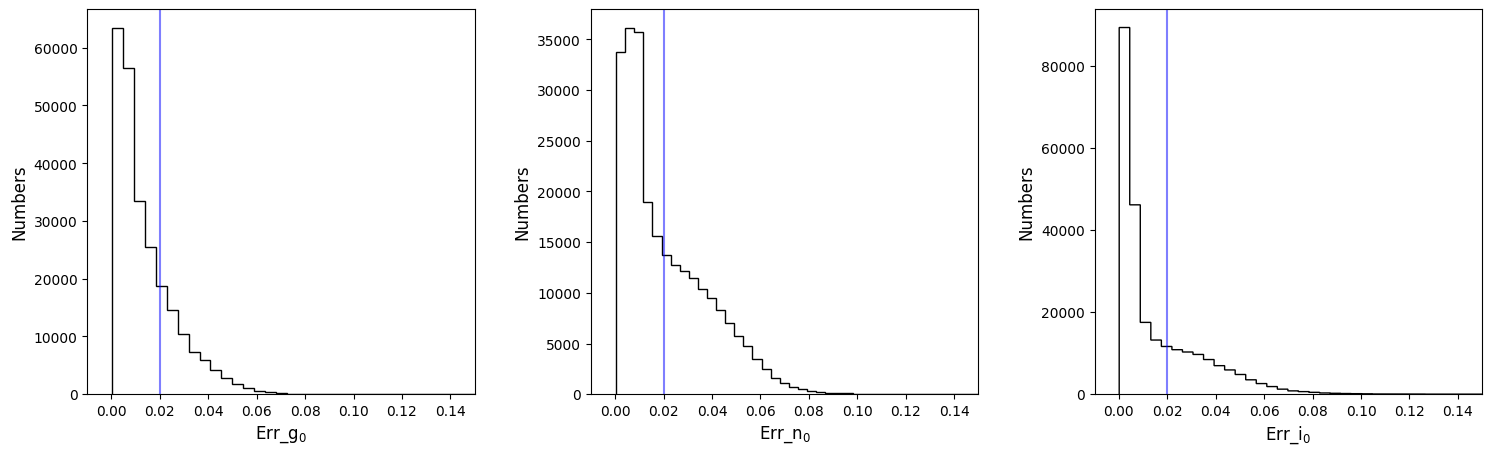

In [4]:
frame = [hsc_df1, hsc_df2, hsc_df3, hsc_df4]
hsc_df_all = pd.concat(frame, ignore_index=True)
print(f'len(hsc_df_all) = {len(hsc_df_all)}') #824054
print(Counter(hsc_df_all['name']), '\n') #Counter({'for': 381593, 'scl': 224203, 'umi': 135112, 'dra': 83146}) 

# Select Objects.  Class=1 means extended sources (background galaxies)
hsc_df = hsc_df_all[(hsc_df_all['cli'] == 0) & (hsc_df_all['clg'] == 0) & (hsc_df_all['cln'] == 0)]
print(f'After class cut, \nlen(hsc_df) = {len(hsc_df)}') #247059
print(Counter(hsc_df['name'])) #Counter({'for': 114831, 'scl': 54920, 'umi': 41894, 'dra': 35414})
hsc_df_rm_inferr = hsc_df[(hsc_df['gpsferr'] != np.inf) & (hsc_df['ipsferr'] != np.inf) & (hsc_df['npsferr'] != np.inf)]
print('hsc_df_rm_inferr =', len(hsc_df_rm_inferr)) #247059
print('\n')

# Plots of mag err
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18,5), gridspec_kw={'wspace':0.3})

ax0.hist(hsc_df_rm_inferr['gpsferr'], bins=100, histtype='step', linestyle='solid', color='k')
ax0.set_xlim([-0.01, 0.15])
ax0.set_xlabel('Err_g$_{0}$', size=12)
ax0.set_ylabel('Numbers', size=12)
ax0.axvline(0.02, 0, 40000, color='blue', linestyle='-', alpha=0.5)
ax1.hist(hsc_df_rm_inferr['npsferr'], bins=500, histtype='step', linestyle='solid', color='k')
ax1.set_xlim([-0.01, 0.15])
ax1.set_xlabel('Err_n$_{0}$', size=12)
ax1.set_ylabel('Numbers', size=12)
ax1.axvline(0.02, 0, 40000, color='blue', linestyle='-', alpha=0.5)
ax2.hist(hsc_df_rm_inferr['ipsferr'], bins=700, histtype='step', linestyle='solid', color='k')
ax2.set_xlim([-0.01, 0.15])
ax2.set_xlabel('Err_i$_{0}$', size=12)
ax2.set_ylabel('Numbers', size=12)
ax2.axvline(0.02, 0, 40000, color='blue', linestyle='-', alpha=0.5)

plt.savefig('hsc_err_gin_histo.png', bbox_inches='tight')

# Apply the magnitude err
hsc_df_cut_mag_err = hsc_df_rm_inferr[(hsc_df_rm_inferr['gpsferr'] < 0.02) & (hsc_df_rm_inferr['ipsferr'] < 0.02) & (hsc_df_rm_inferr['npsferr'] < 0.02)]
print(f'After err_mag cut, \nhsc_df_cut_mag_err = {len(hsc_df_cut_mag_err)}') #140779
hsc_fnx = hsc_df_cut_mag_err[hsc_df_cut_mag_err['name'] == 'for']
hsc_scl = hsc_df_cut_mag_err[hsc_df_cut_mag_err['name'] == 'scl']
hsc_umi = hsc_df_cut_mag_err[hsc_df_cut_mag_err['name'] == 'umi']
hsc_dra = hsc_df_cut_mag_err[hsc_df_cut_mag_err['name'] == 'dra']
print(Counter(hsc_df_cut_mag_err['name'])) #Counter({'for': 67580, 'scl': 25599, 'umi': 24610, 'dra': 22990})

In [5]:
# Fornax

len(test_rgb) = 12869
len(test_agb) = 11931


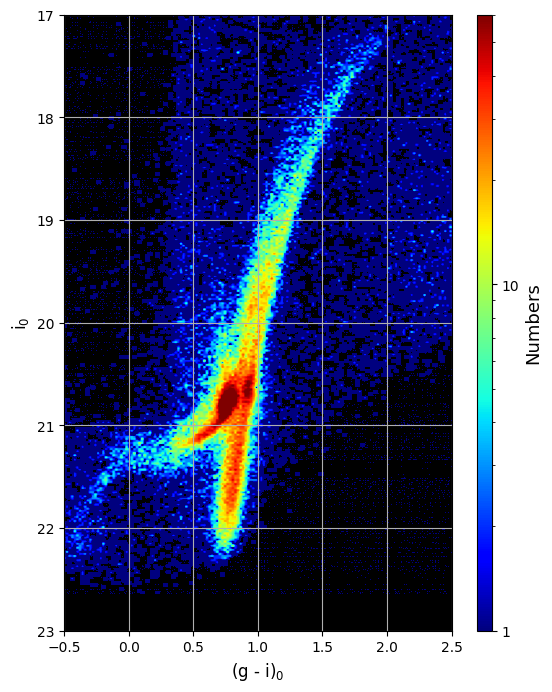

In [6]:
# Get the plots
fig, ax0 = plt.subplots(figsize=(5,8))
x = hsc_fnx['g0']-hsc_fnx['i0']
y = hsc_fnx['i0']

xmin = min(x) ; xmax = max(x) ; ymin = min(y) ; ymax = max(y)
xb = 0.02 ; yb = 0.02
xbins = np.floor((max(x)-min(x))/xb).astype(int) ; ybins = np.floor((max(y)-min(y))/yb).astype(int)

counts, xedges, yedges = np.histogram2d(x, y, bins=(xbins, ybins))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax0.imshow(counts.T, cmap='jet', origin='lower', extent=extent, aspect='auto', norm=LogNorm(vmin=1, vmax=60))
ax0.set_xlim([-0.5, 2.5])
ax0.set_ylim([23, 17])
ax0.set_xlabel('(g - i)$_{0}$', size=12)
ax0.set_ylabel('i$_{0}$', size=12)
ax0.set_facecolor('black')
ax0.grid()
cax = fig.add_axes([ax0.get_position().x1+0.05, ax0.get_position().y0, 0.03, ax0.get_position().height])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Numbers', size=13)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

#ax0.scatter(hsc_fnx_inside_polygon['g0']-hsc_fnx_inside_polygon['i0'], hsc_fnx_inside_polygon['i0'], color='black', s=0.1, alpha=0.1)

# RGB
xmax1 = 1.04
xmin1 = 0.69
ymin1 = 19.6
ymax1 = 22.1
a1 = 0.05
slope1 = (ymin1-ymax1) / (xmax1- xmin1)
test1_y = slope1 * (x - xmax1) + (ymin1-a1)
test1 = hsc_fnx[(test1_y <= y) & (y <= test1_y + 0.5) & (ymin1 <= y) & (y <= ymax1)]
#ax0.plot(x[(xmin1 <= x) & (x <= xmax1)], test1_y[(xmin1 <= x) & (x <= xmax1)], color='w', linewidth=1)
#ax0.scatter(test1['g0']-test1['i0'], test1['i0'], color='hotpink', s=3, alpha=0.5)

xmax2 = 1.44
xmin2 = xmax1
ymin2 = 18.1
ymax2 = ymin1
a2 = 0.05
slope2 = (ymin2-ymax2) / (xmax2- xmin2)
test2_y = slope2 * (x - xmax2) + (ymin2-a2)
test2 = hsc_fnx[(test2_y <= y) & (y <= test2_y + 0.18) & (ymin2 <= y) & (y <= ymax2)]
#ax0.plot(x[(xmin2 <= x) & (x <= xmax2)], test2_y[(xmin2 <= x) & (x <= xmax2)], color='w', linewidth=1)
#ax0.scatter(test2['g0']-test2['i0'], test2['i0'], color='hotpink', s=3, alpha=0.5)

xmax3 = 1.84
xmin3 = xmax2
ymin3 = 17.4
ymax3 = ymin2
a3 = 0.05
slope3 = (ymin3-ymax3) / (xmax3- xmin3)
test3_y = slope3 * (x - xmax3) + (ymin3-a3)
test3 = hsc_fnx[(test3_y <= y) & (y <= test3_y + 0.1) & (ymin3 <= y) & (y <= ymax3)]
#ax0.plot(x[(xmin3 <= x) & (x <= xmax3)], test3_y[(xmin3 <= x) & (x <= xmax3)], color='w', linewidth=1)
#ax0.scatter(test3['g0']-test3['i0'], test3['i0'], color='hotpink', s=3, alpha=0.5)

frame = [test1, test2, test3]
test_rgb = pd.concat(frame, ignore_index=True)
print('len(test_rgb) =', len(test_rgb)) #


# AGB
xmax4 = 0.75
xmin4 = 0.3
ymin4 = 20.7
ymax4 = 21.2
a4 = 0.05
slope4 = (ymin4-ymax4) / (xmax4-xmin4)
test4_y = slope4 * (x - xmax4) + (ymin4-a4)
test4 = hsc_fnx[(test4_y <= y) & (y <= test4_y + 0.2) & (ymin4 <= y) & (y <= ymax4)]
#ax0.plot(x[(xmin4 <= x) & (x <= xmax4)], test4_y[(xmin4 <= x) & (x <= xmax4)], color='w', linewidth=1)
#ax0.scatter(test4['g0']-test4['i0'], test4['i0'], color='cornflowerblue', s=3, alpha=0.5)

xmax5 = 0.95
xmin5 = xmax4
ymin5 = 19.7
ymax5 = ymin4
a5 = 0.05
slope5 = (ymin5-ymax5) / (xmax5-xmin5)
test5_y = slope5 * (x - xmax5) + (ymin5-a5)
test5 = hsc_fnx[(test5_y <= y) & (y <= test5_y + 0.33) & (ymin5 <= y) & (y <= ymax5)]
#ax0.plot(x[(xmin5 <= x) & (x <= xmax5)], test5_y[(xmin5 <= x) & (x <= xmax5)], color='w', linewidth=1)
#ax0.scatter(test5['g0']-test5['i0'], test5['i0'], color='cornflowerblue', s=3, alpha=1)

xmax6 = 1.2
xmin6 = xmax5
ymin6 = 18.8
ymax6 = ymin5
a6 = 0.05
slope6 = (ymin6-ymax6) / (xmax6-xmin6)
test6_y = slope6 * (x - xmax6) + (ymin6-a6)
test6 = hsc_fnx[(test6_y <= y) & (y <= test6_y + 0.15) & (ymin6 <= y) & (y <= ymax6)]
#ax0.plot(x[(xmin6 <= x) & (x <= xmax6)], test6_y[(xmin6 <= x) & (x <= xmax6)], color='w', linewidth=1)
#ax0.scatter(test6['g0']-test6['i0'], test6['i0'], color='cornflowerblue', s=3, alpha=1)

frame = [test4, test5, test6]
test_agb = pd.concat(frame, ignore_index=True)
print('len(test_agb) =', len(test_agb)) #


#plt.show()
plt.savefig('hsc_Fornax_CMD.png', bbox_inches='tight')

In [7]:
print(hsc_fnx.columns.values)

['id' 'ra' 'dec' 'X' 'Y' 'ipsf' 'gpsf' 'npsf' 'ipsferr' 'gpsferr'
 'npsferr' 'cli' 'clg' 'cln' 'a_i' 'a_g' 'a_n' 'g0' 'i0' 'n0' 'name']


len(hsc_df1_gaia) = 381593
len(hsc_df1_gaia_sc) = 114831
len(hsc_df1_gaia_sc_magerr) = 67580
len(hsc_df1_gaia_sc_magerr_availpm) = 31560
len(hsc_df1_gaia_sc_magerr_nonpm) = 36020
clipped mean pmRA pmDE = 0.411 -0.426
clipped std pmRA pmDE = 0.628 1.033
r_a, r_b = 1.884 3.099
len(filtered data) = 21631
len(inside the ellipse) = 20976
len(filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm) = 57651
len(hsc_df1_gaia_sc_magerr_availpm_inside_polygon) = 49704


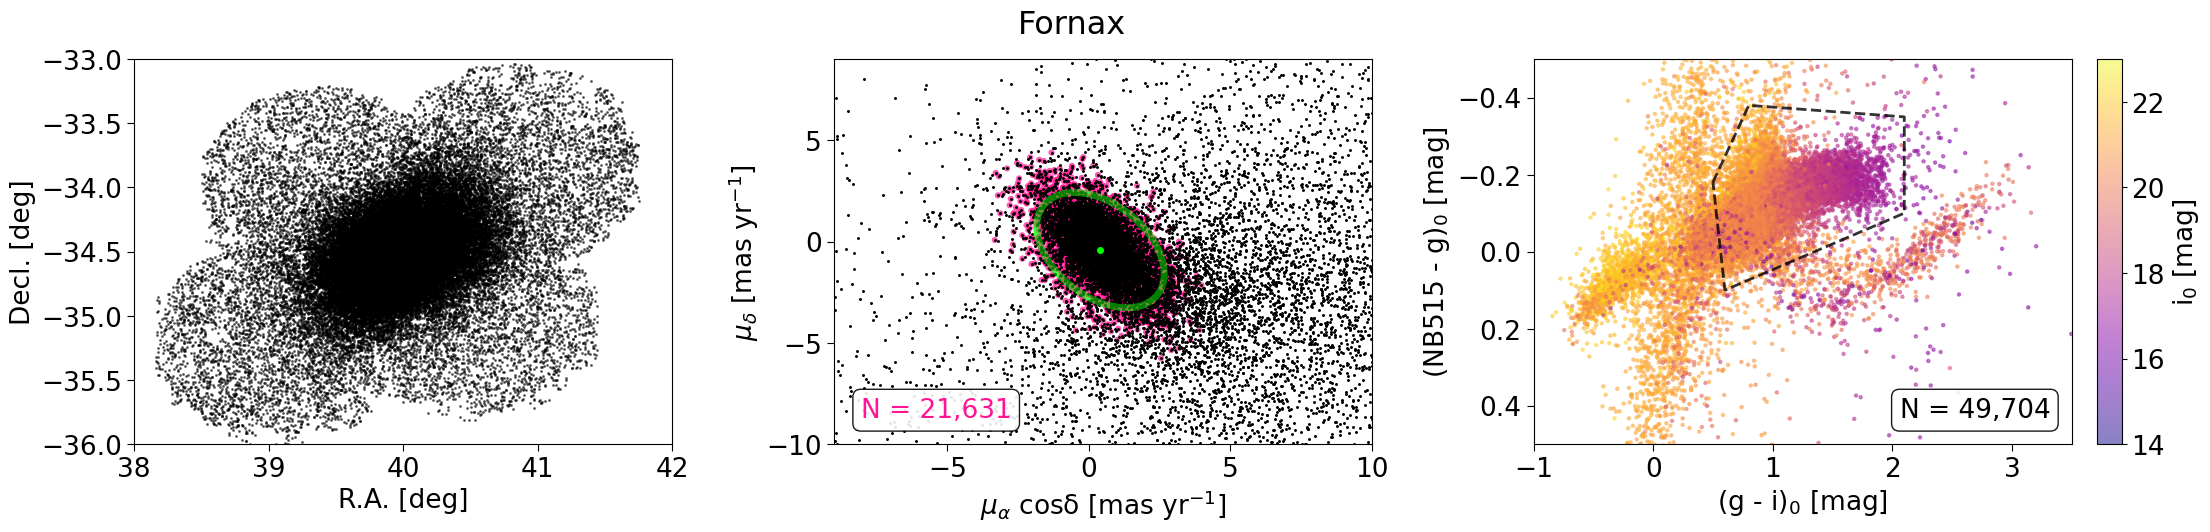

In [16]:
# Test the sample with Gaia DR3
hsc_df1_gaia = pd.read_csv('/emc1/home/jhong5/subaru_hsc/hsc_data/fornax_tpall3e_g24_pm.csv') ; hsc_df1_gaia['name'] = 'for'
print(f'len(hsc_df1_gaia) = {len(hsc_df1_gaia)}') #381593
hsc_df1_gaia_sc = hsc_df1_gaia[(hsc_df1_gaia['cli'] == 0) & (hsc_df1_gaia['clg'] == 0) & (hsc_df1_gaia['cln'] == 0)]
print(f'len(hsc_df1_gaia_sc) = {len(hsc_df1_gaia_sc)}') #114831
hsc_df1_gaia_sc_magerr = hsc_df1_gaia_sc[(hsc_df1_gaia_sc['gpsferr'] < 0.02) & (hsc_df1_gaia_sc['ipsferr'] < 0.02) & (hsc_df1_gaia_sc['npsferr'] < 0.02)]
print(f'len(hsc_df1_gaia_sc_magerr) = {len(hsc_df1_gaia_sc_magerr)}') #67580
hsc_df1_gaia_sc_magerr_availpm = hsc_df1_gaia_sc_magerr[hsc_df1_gaia_sc_magerr['pmRA'].notnull()]
print('len(hsc_df1_gaia_sc_magerr_availpm) =', len(hsc_df1_gaia_sc_magerr_availpm)) #31560
hsc_df1_gaia_sc_magerr_nonpm = hsc_df1_gaia_sc_magerr[hsc_df1_gaia_sc_magerr['pmRA'].isnull()]
print('len(hsc_df1_gaia_sc_magerr_nonpm) =', len(hsc_df1_gaia_sc_magerr_nonpm)) #36020

# Left
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25, 5), gridspec_kw={'wspace':0.3})
fig.suptitle('Fornax', size=23, y=0.98)
alpha = .5 ; s = 5
axs[0].scatter(hsc_df1_gaia_sc_magerr['ra'], hsc_df1_gaia_sc_magerr['dec'], marker='.', s=s, color='k', alpha=.5)
axs[0].set_xlabel('R.A. [deg]', size=19)
axs[0].set_ylabel('Decl. [deg]', size=19)
axs[0].set_xlim([38, 42])
axs[0].set_ylim([-36, -33])
axs[0].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[0].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)
axs[0].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[0].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)


# Middle
#pmra_0, pmdec_0 = 0.380, -0.416 # McConnachie et al. 2020
#r_a, r_b = 2.6, 1.35 # manually / pmRA pmDE std = 8.18, 7.24 # too big
pmRA = hsc_df1_gaia_sc_magerr_availpm['pmRA']
pmDE = hsc_df1_gaia_sc_magerr_availpm['pmDE']
err_pmra = hsc_df1_gaia_sc_magerr_availpm['e_pmRA']
err_pmdec = hsc_df1_gaia_sc_magerr_availpm['e_pmDE']
err_pm = np.sqrt(err_pmra**2 + err_pmdec**2)
# Sigma Clipping
clipped_pmRA = sigma_clip(pmRA, sigma=3, maxiters=10, stdfunc=np.std)
clipped_pmDE = sigma_clip(pmDE, sigma=3, maxiters=10, stdfunc=np.std)
mean_pmRA = np.round(np.mean(clipped_pmRA), 3)
mean_pmDE = np.round(np.mean(clipped_pmDE), 3)
std_pmRA = np.round(np.std(clipped_pmRA), 3)
std_pmDE = np.round(np.std(clipped_pmDE), 3)
print('clipped mean pmRA pmDE =', mean_pmRA, mean_pmDE) #0.411 -0.426
print('clipped std pmRA pmDE =', std_pmRA, std_pmDE) #0.628 1.033
pmra_0, pmdec_0 = mean_pmRA, mean_pmDE
r_a, r_b = np.round(std_pmRA * 3, 3), np.round(std_pmDE * 3, 3)
print('r_a, r_b =', r_a, r_b) #1.884 3.099
axs[1].plot(pmra_0, pmdec_0, marker='o', markersize=4, color='lime')
ellipse = Ellipse(xy=[pmra_0, pmdec_0], width=r_a*2, height=r_b*2, angle=30, edgecolor='lime', fc='None', lw=5, alpha=0.5)
axs[1].add_patch(ellipse)
#center_x, center_y = ellipse.center
#width, height = ellipse.width, ellipse.height
angle = ellipse.angle

def within_ellipse(x, y, x_0, y_0, r_a, r_b):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2

def within_ellipse_w_errpm(x, y, x_0, y_0, r_a, r_b, err_pm):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2 + (3 * err_pm)**2

theta = np.radians(360 - angle)

mask = hsc_df1_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse_w_errpm(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b, np.sqrt(row['e_pmRA']**2 + row['e_pmDE']**2)), axis=1)
filtered_hsc_df1_gaia_sc_magerr_availpm = hsc_df1_gaia_sc_magerr_availpm[mask]
print('len(filtered data) =', len(filtered_hsc_df1_gaia_sc_magerr_availpm)) #21631
axs[1].scatter(filtered_hsc_df1_gaia_sc_magerr_availpm['pmRA'], filtered_hsc_df1_gaia_sc_magerr_availpm['pmDE'], marker='o', s=20, facecolor='deeppink', edgecolor='none', alpha=0.7)
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[1].text(0.05, 0.07, 'N = {0:,.0f}'.format(len(filtered_hsc_df1_gaia_sc_magerr_availpm)), transform=axs[1].transAxes, fontsize=19, color='deeppink', bbox=props)
#filtered_hsc_df1_gaia_sc_magerr_availpm = hsc_df1_gaia_sc_magerr_availpm[~clipped_pmRA.mask & ~clipped_pmDE.mask]
#axs[1].scatter(filtered_hsc_df1_gaia_sc_magerr_availpm['pmRA'], filtered_hsc_df1_gaia_sc_magerr_availpm['pmDE'], marker='o', s=20, facecolor='royalblue', edgecolor='none', alpha=0.7)

axs[1].scatter(hsc_df1_gaia_sc_magerr['pmRA'], hsc_df1_gaia_sc_magerr['pmDE'], marker='.', s=s, color='k', alpha=1)
axs[1].set_xlabel('$\mu_{\\alpha}~\mathrm{cos\delta}$ [mas yr$^{-1}$]', size=19)
axs[1].set_ylabel('$\mu_{\delta}$ [mas yr$^{-1}$]', size=19)
axs[1].set_xlim([-9, 10])
axs[1].set_ylim([-10, 9])
axs[1].add_patch(ellipse)
axs[1].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[1].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)
axs[1].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[1].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)

mask_test = hsc_df1_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b), axis=1)
inside_ellipse_test = hsc_df1_gaia_sc_magerr_availpm[mask_test]
print('len(inside the ellipse) =', len(inside_ellipse_test)) #20976

filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm = pd.concat([hsc_df1_gaia_sc_magerr_nonpm, filtered_hsc_df1_gaia_sc_magerr_availpm], axis=0)
print('len(filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm) =', len(filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm)) #57651


# Right
img = axs[2].scatter(filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['g0'] - filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['i0'], 
                     filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['n0'] - filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['g0'], 
                     marker='o', s=s, c=filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['i0'], cmap='plasma', alpha=alpha)
axs[2].set_xlim([-1, 3.5])
axs[2].set_ylim([0.5, -0.5])
axs[2].set_xlabel('(g - i)$_{0}$ [mag]', size=19)
axs[2].set_ylabel('(NB515 - g)$_{0}$ [mag]', size=19)
axs[2].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[2].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)
axs[2].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[2].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)
#axs[2].grid()
cax = fig.add_axes([axs[2].get_position().x1+0.01, axs[2].get_position().y0, 0.01, axs[2].get_position().height])
cbar = plt.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=19)
cbar.set_label('i$_{0}$ [mag]', size=19)
cbar.mappable.set_clim(vmin=14, vmax=23)
cbar.update_ticks()

coord = [[0.5, -0.18], [0.8, -0.38], [2.1, -0.35], [2.1, -0.1], [0.6, 0.1], [0.5, -0.18]]
xs, ys = zip(*coord)
axs[2].plot(xs, ys, linestyle='--', linewidth=2, alpha=.8, color='k')
polygon = Path(coord)
points = np.vstack((filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['g0'] - filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['i0'], 
                    filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['n0'] - filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['g0'])).T
inside = polygon.contains_points(points)
hsc_df1_gaia_sc_magerr_availpm_inside_polygon = filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm[inside]
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[2].text(0.68, 0.07, 'N = {0:,.0f}'.format(len(hsc_df1_gaia_sc_magerr_availpm_inside_polygon)), transform=axs[2].transAxes, fontsize=19, color='black', bbox=props)
print('len(hsc_df1_gaia_sc_magerr_availpm_inside_polygon) =', len(hsc_df1_gaia_sc_magerr_availpm_inside_polygon)) #49704

#plt.show()
plt.savefig('ccd_select_sample_Fornax_pm.png', bbox_inches='tight')

In [17]:
final_hsc_fnx = hsc_df1_gaia_sc_magerr_availpm_inside_polygon
print(f'len(final_hsc_fnx) = {len(final_hsc_fnx)}') #49704
final_hsc_fnx.to_csv('fornax_tpall3e_g24_radec_members_cut.csv', index=False)
final_hsc_fnx.to_csv('/emc1/home/jhong5/subaru_hsc/hsc_data/fornax_tpall3e_g24_radec_members_cut.csv', index=False)

len(final_hsc_fnx) = 49704


In [18]:
# Sculptor

len(test_rgb) = 3789
len(test_agb) = 160


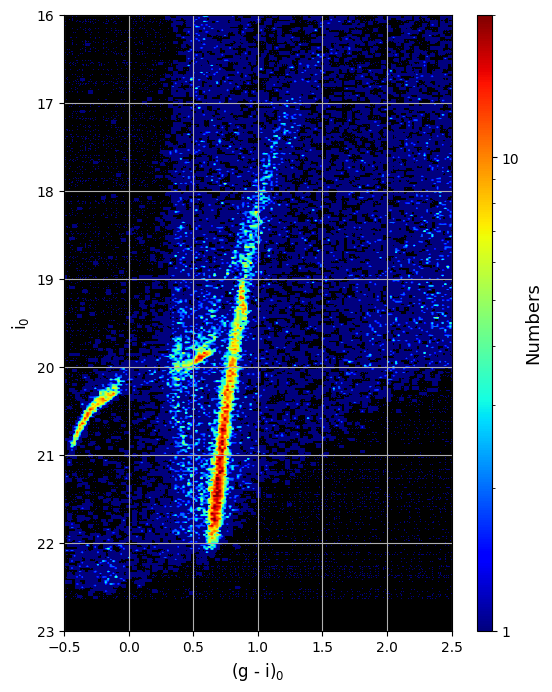

In [19]:
# Get the plots
fig, ax0 = plt.subplots(figsize=(5,8))
x = hsc_scl['g0']-hsc_scl['i0']
y = hsc_scl['i0']

xmin = min(x) ; xmax = max(x) ; ymin = min(y) ; ymax = max(y)
xb = 0.02 ; yb = 0.02
xbins = np.floor((max(x)-min(x))/xb).astype(int) ; ybins = np.floor((max(y)-min(y))/yb).astype(int)

counts, xedges, yedges = np.histogram2d(x, y, bins=(xbins, ybins))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax0.imshow(counts.T, cmap='jet', origin='lower', extent=extent, aspect='auto', norm=LogNorm(vmin=1, vmax=20))
ax0.set_xlim([-0.5, 2.5])
ax0.set_ylim([23, 16])
ax0.set_xlabel('(g - i)$_{0}$', size=12)
ax0.set_ylabel('i$_{0}$', size=12)
ax0.set_facecolor('black')
ax0.grid()
cax = fig.add_axes([ax0.get_position().x1+0.05, ax0.get_position().y0, 0.03, ax0.get_position().height])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Numbers', size=13)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

#ax0.scatter(hsc_fnx_inside_polygon['g0']-hsc_fnx_inside_polygon['i0'], hsc_fnx_inside_polygon['i0'], color='black', s=0.1, alpha=0.1)


# RGB
xmax1 = 0.9
xmin1 = 0.63
ymin1 = 18.5
ymax1 = 22.0
a1 = 0.05
slope1 = (ymin1-ymax1) / (xmax1- xmin1)
test1_y = slope1 * (x - xmax1) + (ymin1-a1)
test1 = hsc_scl[(test1_y <= y) & (y <= test1_y + 0.6) & (ymin1 <= y) & (y <= ymax1)]
#ax0.plot(x[(xmin1 <= x) & (x <= xmax1)], test1_y[(xmin1 <= x) & (x <= xmax1)], color='w', linewidth=1)
#ax0.scatter(test1['g0']-test1['i0'], test1['i0'], color='hotpink', s=3, alpha=0.5)

xmax2 = 1.2
xmin2 = xmax1
ymin2 = 17
ymax2 = ymin1
a2 = 0.05
slope2 = (ymin2-ymax2) / (xmax2- xmin2)
test2_y = slope2 * (x - xmax2) + (ymin2-a2)
test2 = hsc_scl[(test2_y <= y) & (y <= test2_y + 0.18) & (ymin2 <= y) & (y <= ymax2)]
#ax0.plot(x[(xmin2 <= x) & (x <= xmax2)], test2_y[(xmin2 <= x) & (x <= xmax2)], color='w', linewidth=1)
#ax0.scatter(test2['g0']-test2['i0'], test2['i0'], color='hotpink', s=3, alpha=0.5)

frame = [test1, test2]
test_rgb = pd.concat(frame, ignore_index=True)
print('len(test_rgb) =', len(test_rgb)) #


# AGB
"""
xmax4 = -0.30
xmin4 = -0.46
ymin4 = 20.5
ymax4 = 20.95
a4 = 0.05
slope4 = (ymin4-ymax4) / (xmax4-xmin4)
test4_y = slope4 * (x - xmax4) + (ymin4-a4)
test4 = hsc_scl[(test4_y <= y) & (y <= test4_y + 0.05) & (ymin4 <= y) & (y <= ymax4)]
ax0.plot(x[(xmin4 <= x) & (x <= xmax4)], test4_y[(xmin4 <= x) & (x <= xmax4)], color='w', linewidth=1)
ax0.scatter(test4['g0']-test4['i0'], test4['i0'], color='cornflowerblue', s=3, alpha=0.5)

xmax5 = 0.63
xmin5 = xmax4
ymin5 = 19.85
ymax5 = ymin4
a5 = 0.05
slope5 = (ymin5-ymax5) / (xmax5-xmin5)
test5_y = slope5 * (x - xmax5) + (ymin5-a5)
test5 = hsc_scl[(test5_y <= y) & (y <= test5_y + 0.05) & (ymin5 <= y) & (y <= ymax5)]
ax0.plot(x[(xmin5 <= x) & (x <= xmax5)], test5_y[(xmin5 <= x) & (x <= xmax5)], color='w', linewidth=1)
ax0.scatter(test5['g0']-test5['i0'], test5['i0'], color='cornflowerblue', s=3, alpha=0.5)
"""

xmax4 = 0.6
xmin4 = 0.4
ymin4 = 19.85
ymax4 = 20.05
a4 = 0.05
slope4 = (ymin4-ymax4) / (xmax4-xmin4)
test4_y = slope4 * (x - xmax4) + (ymin4-a4)
test4 = hsc_scl[(test4_y <= y) & (y <= test4_y + 0.05) & (ymin4 <= y) & (y <= ymax4)]
#ax0.plot(x[(xmin4 <= x) & (x <= xmax4)], test4_y[(xmin4 <= x) & (x <= xmax4)], color='w', linewidth=1)
#ax0.scatter(test4['g0']-test4['i0'], test4['i0'], color='cornflowerblue', s=3, alpha=0.5)

frame = [test4]
test_agb = pd.concat(frame, ignore_index=True)
print('len(test_agb) =', len(test_agb)) #


#plt.show()
plt.savefig('hsc_Sculptor_CMD.png', bbox_inches='tight')

len(hsc_df2_gaia) = 224203
len(hsc_df2_gaia_sc) = 54920
len(hsc_df2_gaia_sc_magerr) = 25599
len(hsc_df2_gaia_sc_magerr_availpm) = 18727
len(hsc_df2_gaia_sc_magerr_nonpm) = 6872
clipped mean pmRA pmDE = 0.126 -0.144
clipped std pmRA pmDE = 0.415 0.303
r_a, r_b = 1.245 0.909
len(filtered data) = 7453
len(inside the ellipse) = 6263
len(filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm) = 14325
len(hsc_df2_gaia_sc_magerr_availpm_inside_polygon) = 10360


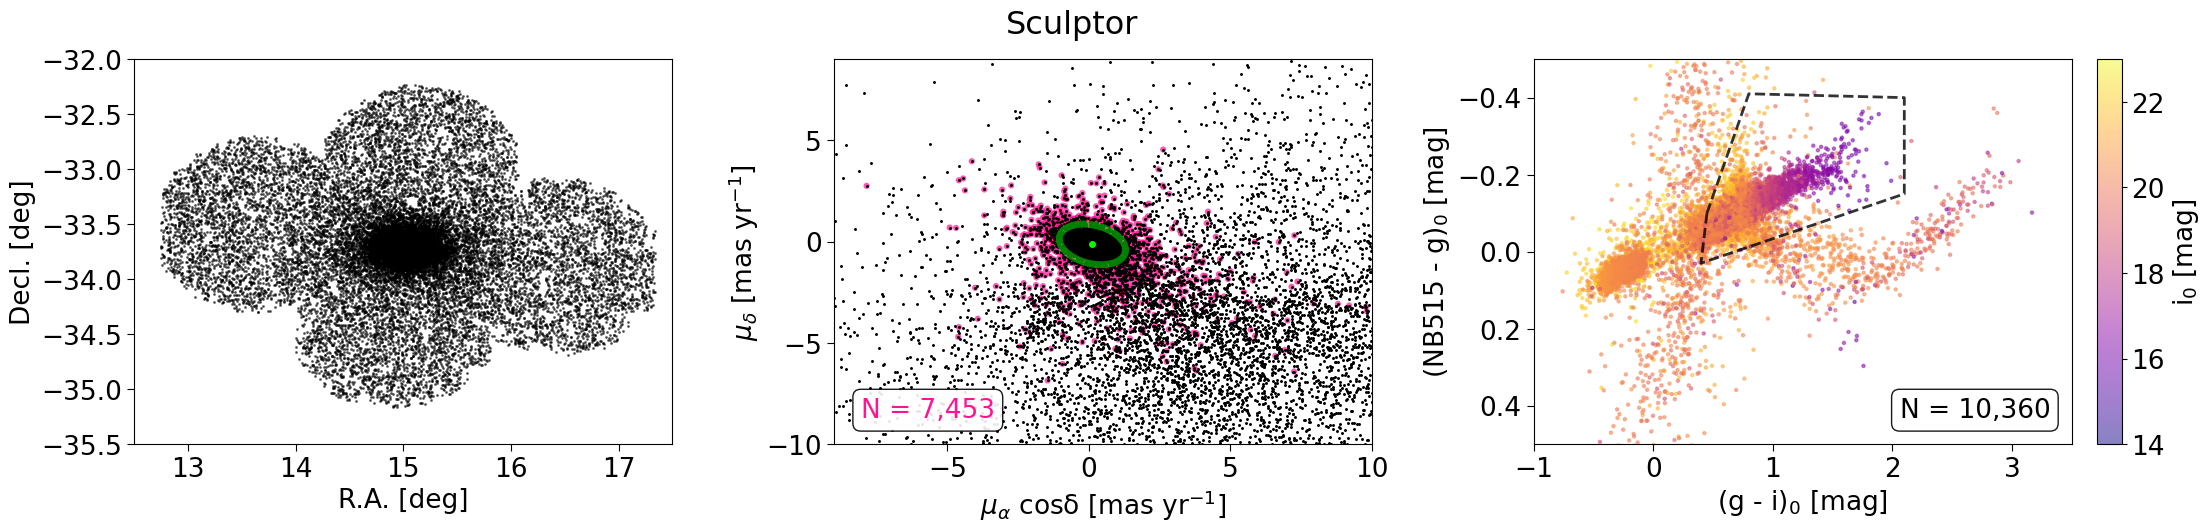

In [48]:
# Test the sample with Gaia DR3
hsc_df2_gaia = pd.read_csv('/emc1/home/jhong5/subaru_hsc/hsc_data/sculptor_tpall3e_g24_pm.csv') ; hsc_df2_gaia['name'] = 'scl'
print(f'len(hsc_df2_gaia) = {len(hsc_df2_gaia)}') #224203
hsc_df2_gaia_sc = hsc_df2_gaia[(hsc_df2_gaia['cli'] == 0) & (hsc_df2_gaia['clg'] == 0) & (hsc_df2_gaia['cln'] == 0)]
print(f'len(hsc_df2_gaia_sc) = {len(hsc_df2_gaia_sc)}') #54920
hsc_df2_gaia_sc_magerr = hsc_df2_gaia_sc[(hsc_df2_gaia_sc['gpsferr'] < 0.02) & (hsc_df2_gaia_sc['ipsferr'] < 0.02) & (hsc_df2_gaia_sc['npsferr'] < 0.02)]
print(f'len(hsc_df2_gaia_sc_magerr) = {len(hsc_df2_gaia_sc_magerr)}') #25599
hsc_df2_gaia_sc_magerr_availpm = hsc_df2_gaia_sc_magerr[hsc_df2_gaia_sc_magerr['pmRA'].notnull()]
print('len(hsc_df2_gaia_sc_magerr_availpm) =', len(hsc_df2_gaia_sc_magerr_availpm)) #18727
hsc_df2_gaia_sc_magerr_nonpm = hsc_df2_gaia_sc_magerr[hsc_df2_gaia_sc_magerr['pmRA'].isnull()]
print('len(hsc_df2_gaia_sc_magerr_nonpm) =', len(hsc_df2_gaia_sc_magerr_nonpm)) #6872

# Left
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25, 5), gridspec_kw={'wspace':0.3})
fig.suptitle('Sculptor', size=23, y=0.98)
alpha = .5 ; s = 5
axs[0].scatter(hsc_df2_gaia_sc_magerr['ra'], hsc_df2_gaia_sc_magerr['dec'], marker='.', s=s, color='k', alpha=.5)
axs[0].set_xlabel('R.A. [deg]', size=19)
axs[0].set_ylabel('Decl. [deg]', size=19)
axs[0].set_xlim([12.5, 17.5])
axs[0].set_ylim([-35.5, -32])
axs[0].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[0].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)
axs[0].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[0].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)


# Middle (McConnachie et al. 2020)
#pmra_0, pmdec_0 = 0.082, -0.133 # McConnachie et al. 2020
#r_a, r_b = 1.3, 0.9 # manually / std of pmRA pmDE = 12.22 10.46
pmRA = hsc_df2_gaia_sc_magerr_availpm['pmRA']
pmDE = hsc_df2_gaia_sc_magerr_availpm['pmDE']
err_pmra = hsc_df2_gaia_sc_magerr_availpm['e_pmRA']
err_pmdec = hsc_df2_gaia_sc_magerr_availpm['e_pmDE']
err_pm = np.sqrt(err_pmra**2 + err_pmdec**2)
# Sigma Clipping
clipped_pmRA = sigma_clip(pmRA, sigma=2, maxiters=10, stdfunc=np.std)
clipped_pmDE = sigma_clip(pmDE, sigma=2, maxiters=10, stdfunc=np.std)
mean_pmRA = np.round(np.mean(clipped_pmRA), 3)
mean_pmDE = np.round(np.mean(clipped_pmDE), 3)
std_pmRA = np.round(np.std(clipped_pmRA), 3)
std_pmDE = np.round(np.std(clipped_pmDE), 3)
print('clipped mean pmRA pmDE =', mean_pmRA, mean_pmDE) #0.126 -0.144
print('clipped std pmRA pmDE =', std_pmRA, std_pmDE) #0.415 0.303
pmra_0, pmdec_0 = mean_pmRA, mean_pmDE
r_a, r_b = np.round(std_pmRA * 3, 3), np.round(std_pmDE * 3, 3)
print('r_a, r_b =', r_a, r_b) #1.245 0.909
axs[1].plot(pmra_0, pmdec_0, marker='o', markersize=4, color='lime')
ellipse = Ellipse(xy=[pmra_0, pmdec_0], width=r_a*2, height=r_b*2, angle=150, edgecolor='lime', fc='None', lw=5, alpha=0.5)
axs[1].add_patch(ellipse)
#center_x, center_y = ellipse.center
#width, height = ellipse.width, ellipse.height
angle = ellipse.angle

def within_ellipse(x, y, x_0, y_0, r_a, r_b):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2

def within_ellipse_w_errpm(x, y, x_0, y_0, r_a, r_b, err_pm):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2 + (3 * err_pm)**2
    
theta = np.radians(360 - angle)

#mask = ( ((pmra_rot - pmra_0_rot) / r_a)**2 + ((pmdec_rot - pmdec_0_rot) / r_b)**2 ) <= 1
mask = hsc_df2_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse_w_errpm(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b, np.sqrt(row['e_pmRA']**2 + row['e_pmDE']**2)), axis=1)
filtered_hsc_df2_gaia_sc_magerr_availpm = hsc_df2_gaia_sc_magerr_availpm[mask]
print('len(filtered data) =', len(filtered_hsc_df2_gaia_sc_magerr_availpm)) #7453
axs[1].scatter(filtered_hsc_df2_gaia_sc_magerr_availpm['pmRA'], filtered_hsc_df2_gaia_sc_magerr_availpm['pmDE'], marker='o', s=20, facecolor='deeppink', edgecolor='none', alpha=0.7)
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[1].text(0.05, 0.07, 'N = {0:,.0f}'.format(len(filtered_hsc_df2_gaia_sc_magerr_availpm)), transform=axs[1].transAxes, fontsize=19, color='deeppink', bbox=props)

axs[1].scatter(hsc_df2_gaia_sc_magerr['pmRA'], hsc_df2_gaia_sc_magerr['pmDE'], marker='.', s=s, color='k', alpha=1)
axs[1].set_xlabel('$\mu_{\\alpha}~\mathrm{cos\delta}$ [mas yr$^{-1}$]', size=19)
axs[1].set_ylabel('$\mu_{\delta}$ [mas yr$^{-1}$]', size=19)
axs[1].set_xlim([-9, 10])
axs[1].set_ylim([-10, 9])
axs[1].add_patch(ellipse)
axs[1].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[1].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)
axs[1].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[1].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)

mask_test = hsc_df2_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b), axis=1)
inside_ellipse_test = hsc_df2_gaia_sc_magerr_availpm[mask_test]
print('len(inside the ellipse) =', len(inside_ellipse_test)) #6263

filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm = pd.concat([hsc_df2_gaia_sc_magerr_nonpm, filtered_hsc_df2_gaia_sc_magerr_availpm], axis=0)
print('len(filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm) =', len(filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm)) #14325



# Right
img = axs[2].scatter(filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['g0'] - filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['i0'], 
                     filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['n0'] - filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['g0'], 
                     marker='o', s=s, c=filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['i0'], cmap='plasma', alpha=alpha)
axs[2].set_xlim([-1, 3.5])
axs[2].set_ylim([0.5, -0.5])
axs[2].set_xlabel('(g - i)$_{0}$ [mag]', size=19)
axs[2].set_ylabel('(NB515 - g)$_{0}$ [mag]', size=19)
axs[2].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[2].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)
axs[2].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[2].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)
#axs[2].grid()
cax = fig.add_axes([axs[2].get_position().x1+0.01, axs[2].get_position().y0, 0.01, axs[2].get_position().height])
cbar = plt.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=19)
cbar.set_label('i$_{0}$ [mag]', size=19)
cbar.mappable.set_clim(vmin=14, vmax=23)
cbar.update_ticks()
coord = [[0.45, -0.1], [0.8, -0.41], [2.1, -0.4], [2.1, -0.15], [0.4, 0.03], [0.45, -0.1]]
xs, ys = zip(*coord)
axs[2].plot(xs, ys, linestyle='--', linewidth=2, alpha=.8, color='k')
polygon = Path(coord)
points = np.vstack((filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['g0'] - filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['i0'], 
                    filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['n0'] - filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['g0'])).T
inside = polygon.contains_points(points)
hsc_df2_gaia_sc_magerr_availpm_inside_polygon = filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm[inside]
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[2].text(0.68, 0.07, 'N = {0:,.0f}'.format(len(hsc_df2_gaia_sc_magerr_availpm_inside_polygon)), transform=axs[2].transAxes, fontsize=19, color='black', bbox=props)
print('len(hsc_df2_gaia_sc_magerr_availpm_inside_polygon) =', len(hsc_df2_gaia_sc_magerr_availpm_inside_polygon)) #10360

#plt.show()
plt.savefig('ccd_select_sample_Sculptor_pm.png', bbox_inches='tight')

In [27]:
final_hsc_scl = hsc_df2_gaia_sc_magerr_availpm_inside_polygon
print(f'len(final_hsc_scl) = {len(final_hsc_scl)}') #10360
final_hsc_scl.to_csv('sculptor_tpall3e_g24_radec_members_cut.csv', index=False)
final_hsc_scl.to_csv('/emc1/home/jhong5/subaru_hsc/hsc_data/sculptor_tpall3e_g24_radec_members_cut.csv', index=False)

len(final_hsc_scl) = 10360


In [28]:
# Ursa Minor

len(test_rgb) = 1404


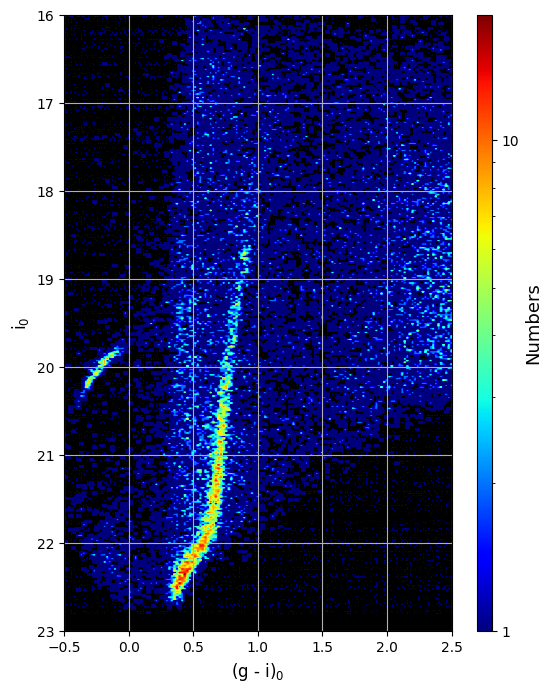

In [29]:
# Get the plots
fig, ax0 = plt.subplots(figsize=(5,8))
x = hsc_umi['g0']-hsc_umi['i0']
y = hsc_umi['i0']

xmin = min(x) ; xmax = max(x) ; ymin = min(y) ; ymax = max(y)
xb = 0.02 ; yb = 0.02
xbins = np.floor((max(x)-min(x))/xb).astype(int) ; ybins = np.floor((max(y)-min(y))/yb).astype(int)

counts, xedges, yedges = np.histogram2d(x, y, bins=(xbins, ybins))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax0.imshow(counts.T, cmap='jet', origin='lower', extent=extent, aspect='auto', norm=LogNorm(vmin=1, vmax=18))
ax0.set_xlim([-0.5, 2.5])
ax0.set_ylim([23, 16])
ax0.set_xlabel('(g - i)$_{0}$', size=12)
ax0.set_ylabel('i$_{0}$', size=12)
ax0.set_facecolor('black')
ax0.grid()
cax = fig.add_axes([ax0.get_position().x1+0.05, ax0.get_position().y0, 0.03, ax0.get_position().height])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Numbers', size=13)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

#ax0.scatter(hsc_fnx_inside_polygon['g0']-hsc_fnx_inside_polygon['i0'], hsc_fnx_inside_polygon['i0'], color='black', s=0.1, alpha=0.1)


# RGB
xmax1 = 0.87
xmin1 = 0.60
ymin1 = 18.8
ymax1 = 21.9
a1 = 0.05
slope1 = (ymin1-ymax1) / (xmax1- xmin1)
test1_y = slope1 * (x - xmax1) + (ymin1-a1)
test1 = hsc_umi[(test1_y <= y) & (y <= test1_y + 0.5) & (ymin1 <= y) & (y <= ymax1)]
#ax0.plot(x[(xmin1 <= x) & (x <= xmax1)], test1_y[(xmin1 <= x) & (x <= xmax1)], color='w', linewidth=1)
#ax0.scatter(test1['g0']-test1['i0'], test1['i0'], color='hotpink', s=3, alpha=0.5)

#xmax2 = 1.2
#xmin2 = xmax1
#ymin2 = 17
#ymax2 = ymin1
#a2 = 0.05
#slope2 = (ymin2-ymax2) / (xmax2- xmin2)
#test2_y = slope2 * (x - xmax2) + (ymin2-a2)
#test2 = hsc_umi[(test2_y <= y) & (y <= test2_y + 0.18) & (ymin2 <= y) & (y <= ymax2)]
#ax0.plot(x[(xmin2 <= x) & (x <= xmax2)], test2_y[(xmin2 <= x) & (x <= xmax2)], color='w', linewidth=1)
#ax0.scatter(test2['g0']-test2['i0'], test2['i0'], color='hotpink', s=3, alpha=0.5)

frame = [test1]
test_rgb = pd.concat(frame, ignore_index=True)
print('len(test_rgb) =', len(test_rgb)) #


# AGB
"""
xmax4 = -0.30
xmin4 = -0.46
ymin4 = 20.5
ymax4 = 20.95
a4 = 0.05
slope4 = (ymin4-ymax4) / (xmax4-xmin4)
test4_y = slope4 * (x - xmax4) + (ymin4-a4)
test4 = hsc_umi[(test4_y <= y) & (y <= test4_y + 0.05) & (ymin4 <= y) & (y <= ymax4)]
ax0.plot(x[(xmin4 <= x) & (x <= xmax4)], test4_y[(xmin4 <= x) & (x <= xmax4)], color='w', linewidth=1)
ax0.scatter(test4['g0']-test4['i0'], test4['i0'], color='cornflowerblue', s=3, alpha=0.5)

xmax5 = 0.63
xmin5 = xmax4
ymin5 = 19.85
ymax5 = ymin4
a5 = 0.05
slope5 = (ymin5-ymax5) / (xmax5-xmin5)
test5_y = slope5 * (x - xmax5) + (ymin5-a5)
test5 = hsc_umi[(test5_y <= y) & (y <= test5_y + 0.05) & (ymin5 <= y) & (y <= ymax5)]
ax0.plot(x[(xmin5 <= x) & (x <= xmax5)], test5_y[(xmin5 <= x) & (x <= xmax5)], color='w', linewidth=1)
ax0.scatter(test5['g0']-test5['i0'], test5['i0'], color='cornflowerblue', s=3, alpha=0.5)

xmax4 = 0.6
xmin4 = 0.4
ymin4 = 19.85
ymax4 = 20.05
a4 = 0.05
slope4 = (ymin4-ymax4) / (xmax4-xmin4)
test4_y = slope4 * (x - xmax4) + (ymin4-a4)
test4 = hsc_umi[(test4_y <= y) & (y <= test4_y + 0.05) & (ymin4 <= y) & (y <= ymax4)]
ax0.plot(x[(xmin4 <= x) & (x <= xmax4)], test4_y[(xmin4 <= x) & (x <= xmax4)], color='w', linewidth=1)
ax0.scatter(test4['g0']-test4['i0'], test4['i0'], color='cornflowerblue', s=3, alpha=0.5)

frame = [test4]
test_agb = pd.concat(frame, ignore_index=True)
print(len(test_agb)) #
"""

#plt.show()
plt.savefig('hsc_Ursaminor_CMD.png', bbox_inches='tight')

len(hsc_df3_gaia) = 135112
len(hsc_df3_gaia_sc) = 41894
len(hsc_df3_gaia_sc_magerr) = 24610
len(hsc_df3_gaia_sc_magerr_availpm) = 17271
len(hsc_df3_gaia_sc_magerr_nonpm) = 7339
clipped mean pmRA pmDE = -0.139 -0.013
clipped std pmRA pmDE = 0.311 0.322
r_a, r_b = 0.933 0.966
len(filtered data) = 3793
len(inside the ellipse) = 1952
len(filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm) = 11132
len(hsc_df3_gaia_sc_magerr_availpm_inside_polygon) = 5891


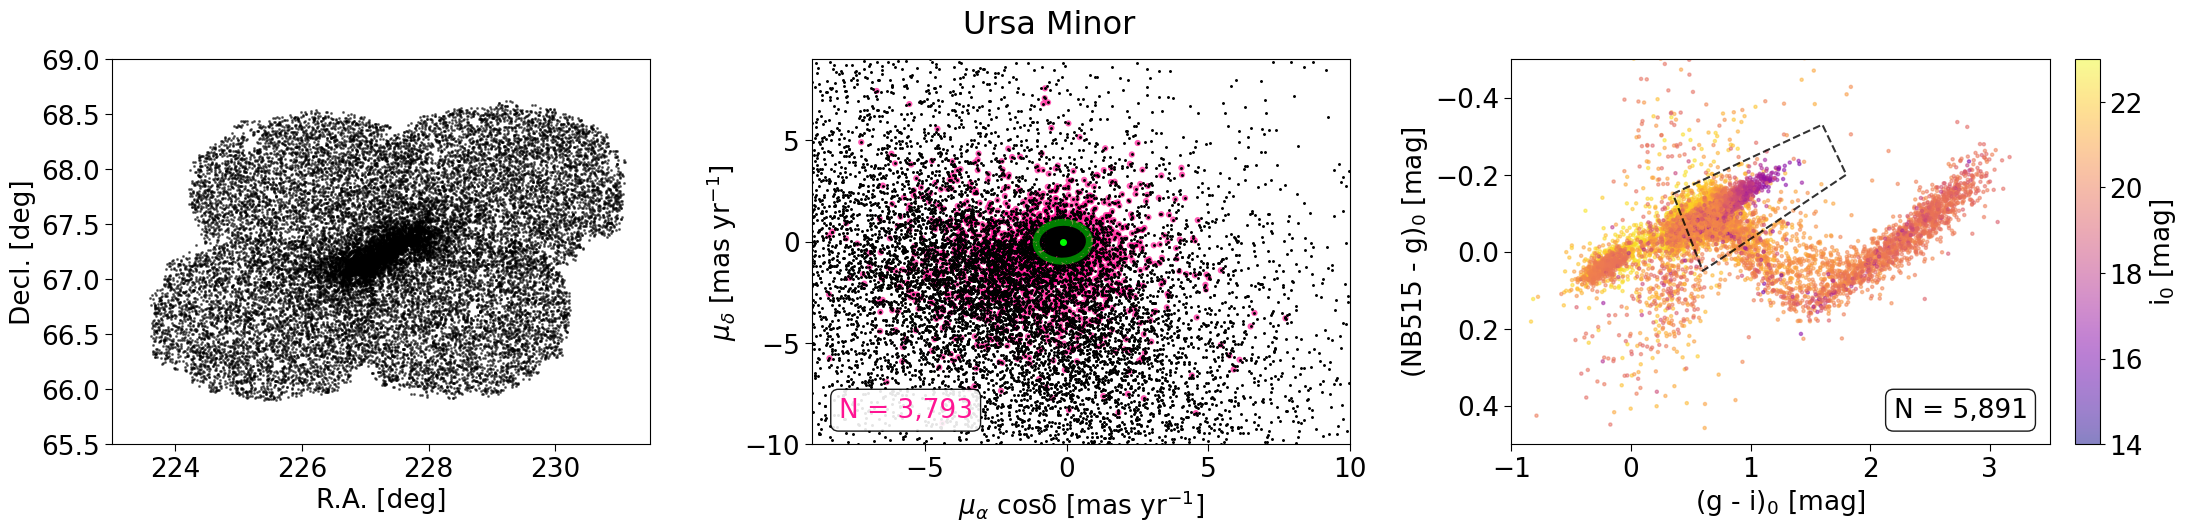

In [37]:
# Test the sample with Gaia DR3
hsc_df3_gaia = pd.read_csv('/emc1/home/jhong5/subaru_hsc/hsc_data/ursaminor_tpall3e_g24_pm.csv') ; hsc_df3_gaia['name'] = 'umi'
print(f'len(hsc_df3_gaia) = {len(hsc_df3_gaia)}') #135112
hsc_df3_gaia_sc = hsc_df3_gaia[(hsc_df3_gaia['cli'] == 0) & (hsc_df3_gaia['clg'] == 0) & (hsc_df3_gaia['cln'] == 0)]
print(f'len(hsc_df3_gaia_sc) = {len(hsc_df3_gaia_sc)}') #41894
hsc_df3_gaia_sc_magerr = hsc_df3_gaia_sc[(hsc_df3_gaia_sc['gpsferr'] < 0.02) & (hsc_df3_gaia_sc['ipsferr'] < 0.02) & (hsc_df3_gaia_sc['npsferr'] < 0.02)]
print(f'len(hsc_df3_gaia_sc_magerr) = {len(hsc_df3_gaia_sc_magerr)}') #24610
hsc_df3_gaia_sc_magerr_availpm = hsc_df3_gaia_sc_magerr[hsc_df3_gaia_sc_magerr['pmRA'].notnull()]
print('len(hsc_df3_gaia_sc_magerr_availpm) =', len(hsc_df3_gaia_sc_magerr_availpm)) #17271
hsc_df3_gaia_sc_magerr_nonpm = hsc_df3_gaia_sc_magerr[hsc_df3_gaia_sc_magerr['pmRA'].isnull()]
print('len(hsc_df3_gaia_sc_magerr_nonpm) =', len(hsc_df3_gaia_sc_magerr_nonpm)) #7339
9# Left
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25, 5), gridspec_kw={'wspace':0.3})
fig.suptitle('Ursa Minor', size=23, y=0.98)
alpha = .5 ; s = 5
axs[0].scatter(hsc_df3_gaia_sc_magerr['ra'], hsc_df3_gaia_sc_magerr['dec'], marker='.', s=s, color='k', alpha=.5)
axs[0].set_xlabel('R.A. [deg]', size=19)
axs[0].set_ylabel('Decl. [deg]', size=19)
axs[0].set_xlim([223, 231.5])
axs[0].set_ylim([65.5, 69])
axs[0].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[0].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)
axs[0].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[0].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)


# Middle
#pmra_0, pmdec_0 = -0.16, 0.06 # McConnachie et al. 2020
#r_a, r_b = 0.9, 0.9 # manually / std of pmRA pmDE = 12.22 10.46
pmRA = hsc_df3_gaia_sc_magerr_availpm['pmRA']
pmDE = hsc_df3_gaia_sc_magerr_availpm['pmDE']
err_pmra = hsc_df3_gaia_sc_magerr_availpm['e_pmRA']
err_pmdec = hsc_df3_gaia_sc_magerr_availpm['e_pmDE']
err_pm = np.sqrt(err_pmra**2 + err_pmdec**2)
# Sigma Clipping
clipped_pmRA = sigma_clip(pmRA, sigma=1.5, maxiters=10, stdfunc=np.std)
clipped_pmDE = sigma_clip(pmDE, sigma=1.5, maxiters=10, stdfunc=np.std)
mean_pmRA = np.round(np.mean(clipped_pmRA), 3)
mean_pmDE = np.round(np.mean(clipped_pmDE), 3)
std_pmRA = np.round(np.std(clipped_pmRA), 3)
std_pmDE = np.round(np.std(clipped_pmDE), 3)
print('clipped mean pmRA pmDE =', mean_pmRA, mean_pmDE) #-0.139 -0.013
print('clipped std pmRA pmDE =', std_pmRA, std_pmDE) #0.311 0.322
pmra_0, pmdec_0 = mean_pmRA, mean_pmDE
r_a, r_b = np.round(std_pmRA * 3, 3), np.round(std_pmDE * 3, 3)
print('r_a, r_b =', r_a, r_b) #0.933 0.966
axs[1].plot(pmra_0, pmdec_0, marker='o', markersize=4, color='lime')
ellipse = Ellipse(xy=[pmra_0, pmdec_0], width=r_a*2, height=r_b*2, angle=150, edgecolor='lime', fc='None', lw=5, alpha=0.5)
axs[1].add_patch(ellipse)
#center_x, center_y = ellipse.center
#width, height = ellipse.width, ellipse.height
angle = ellipse.angle

def within_ellipse(x, y, x_0, y_0, r_a, r_b):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2

def within_ellipse_w_errpm(x, y, x_0, y_0, r_a, r_b, err_pm):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2 + (3 * err_pm)**2

theta = np.radians(360 - angle)

#mask = ( ((pmra_rot - pmra_0_rot) / r_a)**2 + ((pmdec_rot - pmdec_0_rot) / r_b)**2 ) <= 1
mask = hsc_df3_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse_w_errpm(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b, np.sqrt(row['e_pmRA']**2 + row['e_pmDE']**2)), axis=1)
filtered_hsc_df3_gaia_sc_magerr_availpm = hsc_df3_gaia_sc_magerr_availpm[mask]
print('len(filtered data) =', len(filtered_hsc_df3_gaia_sc_magerr_availpm)) #3793
axs[1].scatter(filtered_hsc_df3_gaia_sc_magerr_availpm['pmRA'], filtered_hsc_df3_gaia_sc_magerr_availpm['pmDE'], marker='o', s=20, facecolor='deeppink', edgecolor='none', alpha=0.7)
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[1].text(0.05, 0.07, 'N = {0:,.0f}'.format(len(filtered_hsc_df3_gaia_sc_magerr_availpm)), transform=axs[1].transAxes, fontsize=19, color='deeppink', bbox=props)

axs[1].scatter(hsc_df3_gaia_sc_magerr['pmRA'], hsc_df3_gaia_sc_magerr['pmDE'], marker='.', s=s, color='k', alpha=1)
axs[1].set_xlabel('$\mu_{\\alpha}~\mathrm{cos\delta}$ [mas yr$^{-1}$]', size=19)
axs[1].set_ylabel('$\mu_{\delta}$ [mas yr$^{-1}$]', size=19)
axs[1].set_xlim([-9, 10])
axs[1].set_ylim([-10, 9])
axs[1].add_patch(ellipse)
axs[1].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[1].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)
axs[1].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[1].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)

mask_test = hsc_df3_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b), axis=1)
inside_ellipse_test = hsc_df3_gaia_sc_magerr_availpm[mask_test]
print('len(inside the ellipse) =', len(inside_ellipse_test)) #1952

filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm = pd.concat([hsc_df3_gaia_sc_magerr_nonpm, filtered_hsc_df3_gaia_sc_magerr_availpm], axis=0)
print('len(filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm) =', len(filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm)) #11132


# Right
img = axs[2].scatter(filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['g0'] - filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['i0'], 
                     filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['n0'] - filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['g0'], 
                     marker='o', s=s, c=filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['i0'], cmap='plasma', alpha=alpha)
axs[2].set_xlim([-1, 3.5])
axs[2].set_ylim([0.5, -0.5])
axs[2].set_xlabel('(g - i)$_{0}$ [mag]', size=19)
axs[2].set_ylabel('(NB515 - g)$_{0}$ [mag]', size=19)
axs[2].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[2].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)
axs[2].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[2].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)
#axs[2].grid()
cax = fig.add_axes([axs[2].get_position().x1+0.01, axs[2].get_position().y0, 0.01, axs[2].get_position().height])
cbar = plt.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=19)
cbar.set_label('i$_{0}$ [mag]', size=19)
cbar.mappable.set_clim(vmin=14, vmax=23)
cbar.update_ticks()
coord = [[0.35, -0.15], [1.6, -0.33], [1.8, -0.2], [0.6, 0.05], [0.35, -0.15]]
xs, ys = zip(*coord)
axs[2].plot(xs, ys, linestyle='--', linewidth=1.5, alpha=.8, color='k')
polygon = Path(coord)
points = np.vstack((filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['g0'] - filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['i0'], 
                    filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['n0'] - filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['g0'])).T
inside = polygon.contains_points(points)
hsc_df3_gaia_sc_magerr_availpm_inside_polygon = filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm[inside]
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[2].text(0.71, 0.07, 'N = {0:,.0f}'.format(len(hsc_df3_gaia_sc_magerr_availpm_inside_polygon)), transform=axs[2].transAxes, fontsize=19, color='black', bbox=props)
print('len(hsc_df3_gaia_sc_magerr_availpm_inside_polygon) =', len(hsc_df3_gaia_sc_magerr_availpm_inside_polygon)) #5891

#plt.show()
plt.savefig('ccd_select_sample_Ursaminor_pm.png', bbox_inches='tight')

In [38]:
final_hsc_umi = hsc_df3_gaia_sc_magerr_availpm_inside_polygon
print(f'len(final_hsc_umi) = {len(final_hsc_umi)}') #5891
final_hsc_umi.to_csv('ursaminor_tpall3e_g24_radec_members_cut.csv', index=False)
final_hsc_umi.to_csv('/emc1/home/jhong5/subaru_hsc/hsc_data/ursaminor_tpall3e_g24_radec_members_cut.csv', index=False)

len(final_hsc_umi) = 5891


In [36]:
# Draco

len(test_rgb) = 1320


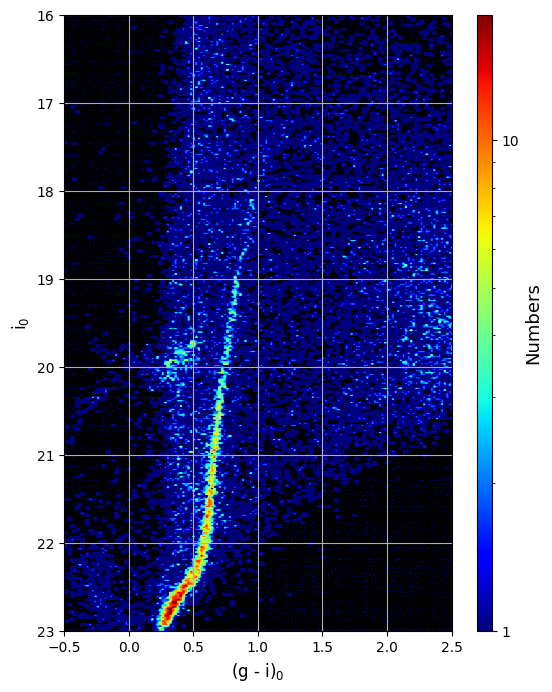

In [39]:
# Get the plots
fig, ax0 = plt.subplots(figsize=(5,8))
x = hsc_dra['g0']-hsc_dra['i0']
y = hsc_dra['i0']

xmin = min(x) ; xmax = max(x) ; ymin = min(y) ; ymax = max(y)
xb = 0.02 ; yb = 0.02
xbins = np.floor((max(x)-min(x))/xb).astype(int) ; ybins = np.floor((max(y)-min(y))/yb).astype(int)

counts, xedges, yedges = np.histogram2d(x, y, bins=(xbins, ybins))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax0.imshow(counts.T, cmap='jet', origin='lower', extent=extent, aspect='auto', norm=LogNorm(vmin=1, vmax=18))
ax0.set_xlim([-0.5, 2.5])
ax0.set_ylim([23, 16])
ax0.set_xlabel('(g - i)$_{0}$', size=12)
ax0.set_ylabel('i$_{0}$', size=12)
ax0.set_facecolor('black')
ax0.grid()
cax = fig.add_axes([ax0.get_position().x1+0.05, ax0.get_position().y0, 0.03, ax0.get_position().height])
cbar = plt.colorbar(im, cax=cax)
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
cbar.set_label('Numbers', size=13)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

#ax0.scatter(hsc_fnx_inside_polygon['g0']-hsc_fnx_inside_polygon['i0'], hsc_fnx_inside_polygon['i0'], color='black', s=0.1, alpha=0.1)


# RGB
xmax1 = 0.85
xmin1 = 0.55
ymin1 = 18.8
ymax1 = 22.2
a1 = 0.05
slope1 = (ymin1-ymax1) / (xmax1- xmin1)
test1_y = slope1 * (x - xmax1) + (ymin1-a1)
test1 = hsc_dra[(test1_y <= y) & (y <= test1_y + 0.4) & (ymin1 <= y) & (y <= ymax1)]
#ax0.plot(x[(xmin1 <= x) & (x <= xmax1)], test1_y[(xmin1 <= x) & (x <= xmax1)], color='w', linewidth=1)
#ax0.scatter(test1['g0']-test1['i0'], test1['i0'], color='hotpink', s=3, alpha=0.5)

#xmax2 = 1.2
#xmin2 = xmax1
#ymin2 = 17
#ymax2 = ymin1
#a2 = 0.05
#slope2 = (ymin2-ymax2) / (xmax2- xmin2)
#test2_y = slope2 * (x - xmax2) + (ymin2-a2)
#test2 = hsc_dra[(test2_y <= y) & (y <= test2_y + 0.18) & (ymin2 <= y) & (y <= ymax2)]
#ax0.plot(x[(xmin2 <= x) & (x <= xmax2)], test2_y[(xmin2 <= x) & (x <= xmax2)], color='w', linewidth=1)
#ax0.scatter(test2['g0']-test2['i0'], test2['i0'], color='hotpink', s=3, alpha=0.5)

frame = [test1]
test_rgb = pd.concat(frame, ignore_index=True)
print('len(test_rgb) =', len(test_rgb)) #


# AGB
"""
xmax4 = -0.30
xmin4 = -0.46
ymin4 = 20.5
ymax4 = 20.95
a4 = 0.05
slope4 = (ymin4-ymax4) / (xmax4-xmin4)
test4_y = slope4 * (x - xmax4) + (ymin4-a4)
test4 = hsc_dra[(test4_y <= y) & (y <= test4_y + 0.05) & (ymin4 <= y) & (y <= ymax4)]
ax0.plot(x[(xmin4 <= x) & (x <= xmax4)], test4_y[(xmin4 <= x) & (x <= xmax4)], color='w', linewidth=1)
ax0.scatter(test4['g0']-test4['i0'], test4['i0'], color='cornflowerblue', s=3, alpha=0.5)

xmax5 = 0.63
xmin5 = xmax4
ymin5 = 19.85
ymax5 = ymin4
a5 = 0.05
slope5 = (ymin5-ymax5) / (xmax5-xmin5)
test5_y = slope5 * (x - xmax5) + (ymin5-a5)
test5 = hsc_dra[(test5_y <= y) & (y <= test5_y + 0.05) & (ymin5 <= y) & (y <= ymax5)]
ax0.plot(x[(xmin5 <= x) & (x <= xmax5)], test5_y[(xmin5 <= x) & (x <= xmax5)], color='w', linewidth=1)
ax0.scatter(test5['g0']-test5['i0'], test5['i0'], color='cornflowerblue', s=3, alpha=0.5)

xmax4 = 0.6
xmin4 = 0.4
ymin4 = 19.85
ymax4 = 20.05
a4 = 0.05
slope4 = (ymin4-ymax4) / (xmax4-xmin4)
test4_y = slope4 * (x - xmax4) + (ymin4-a4)
test4 = hsc_dra[(test4_y <= y) & (y <= test4_y + 0.05) & (ymin4 <= y) & (y <= ymax4)]
ax0.plot(x[(xmin4 <= x) & (x <= xmax4)], test4_y[(xmin4 <= x) & (x <= xmax4)], color='w', linewidth=1)
ax0.scatter(test4['g0']-test4['i0'], test4['i0'], color='cornflowerblue', s=3, alpha=0.5)

frame = [test4]
test_agb = pd.concat(frame, ignore_index=True)
print('len(test_agb) =', len(test_agb)) #
"""

#plt.show()
plt.savefig('hsc_Draco_CMD.png', bbox_inches='tight')

len(hsc_df4_gaia) = 83146
len(hsc_df4_gaia_sc) = 35414
len(hsc_df4_gaia_sc_magerr) = 22990
len(hsc_df4_gaia_sc_magerr_availpm) = 14840
len(hsc_df4_gaia_sc_magerr_nonpm) = 8150
clipped mean pmRA pmDE = -0.033 -0.206
clipped std pmRA pmDE = 0.351 0.31
r_a, r_b = 1.053 0.93
len(filtered data) = 3376
len(inside the ellipse) = 1715
len(filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm) = 11526
len(hsc_df4_gaia_sc_magerr_availpm_inside_polygon) = 5430


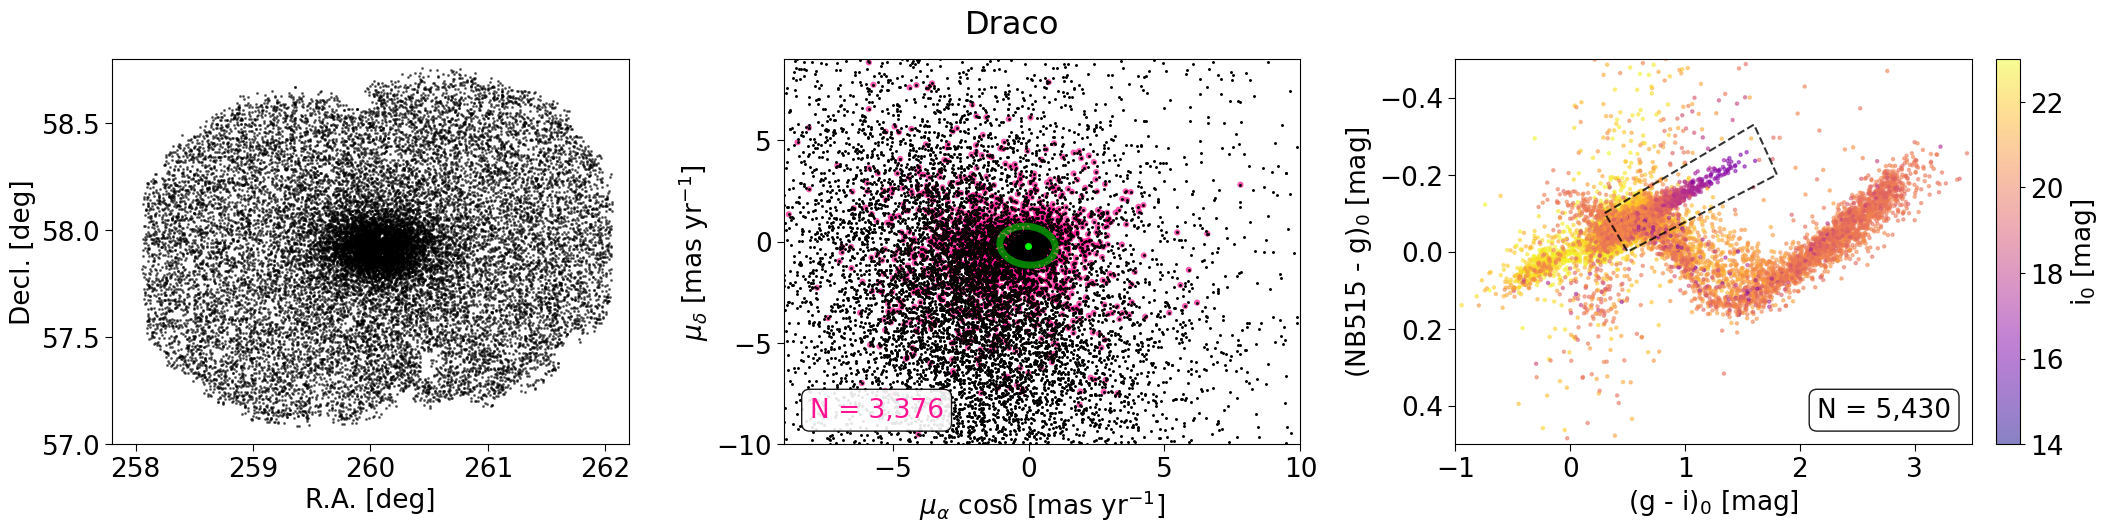

In [46]:
# Test the sample with Gaia DR3
hsc_df4_gaia = pd.read_csv('/emc1/home/jhong5/subaru_hsc/hsc_data/draco_tpall3e_g24_pm.csv') ; hsc_df4_gaia['name'] = 'dra'
print(f'len(hsc_df4_gaia) = {len(hsc_df4_gaia)}') #83146
hsc_df4_gaia_sc = hsc_df4_gaia[(hsc_df4_gaia['cli'] == 0) & (hsc_df4_gaia['clg'] == 0) & (hsc_df4_gaia['cln'] == 0)]
print(f'len(hsc_df4_gaia_sc) = {len(hsc_df4_gaia_sc)}') #35414
hsc_df4_gaia_sc_magerr = hsc_df4_gaia_sc[(hsc_df4_gaia_sc['gpsferr'] < 0.02) & (hsc_df4_gaia_sc['ipsferr'] < 0.02) & (hsc_df4_gaia_sc['npsferr'] < 0.02)]
print(f'len(hsc_df4_gaia_sc_magerr) = {len(hsc_df4_gaia_sc_magerr)}') #22990
hsc_df4_gaia_sc_magerr_availpm = hsc_df4_gaia_sc_magerr[hsc_df4_gaia_sc_magerr['pmRA'].notnull()]
print('len(hsc_df4_gaia_sc_magerr_availpm) =', len(hsc_df4_gaia_sc_magerr_availpm)) #14840
hsc_df4_gaia_sc_magerr_nonpm = hsc_df4_gaia_sc_magerr[hsc_df4_gaia_sc_magerr['pmRA'].isnull()]
print('len(hsc_df4_gaia_sc_magerr_nonpm) =', len(hsc_df4_gaia_sc_magerr_nonpm)) #8150

# Left
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 5), gridspec_kw={'wspace':0.3})
fig.suptitle('Draco', size=23, y=0.98)
alpha = .5 ; s = 5
axs[0].scatter(hsc_df4_gaia_sc_magerr['ra'], hsc_df4_gaia_sc_magerr['dec'], marker='.', s=s, color='k', alpha=.5)
axs[0].set_xlabel('R.A. [deg]', size=19)
axs[0].set_ylabel('Decl. [deg]', size=19)
axs[0].set_xlim([257.8, 262.2])
axs[0].set_ylim([57, 58.8])
axs[0].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[0].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)
axs[0].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[0].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)


# Middle
#pmra_0, pmdec_0 = -0.01, 0.2 # McConnachie et al. 2020
#r_a, r_b = 0.85, 0.85 # manually / std of pmRA pmDE = 12.22 10.46
pmRA = hsc_df4_gaia_sc_magerr_availpm['pmRA']
pmDE = hsc_df4_gaia_sc_magerr_availpm['pmDE']
err_pmra = hsc_df4_gaia_sc_magerr_availpm['e_pmRA']
err_pmdec = hsc_df4_gaia_sc_magerr_availpm['e_pmDE']
err_pm = np.sqrt(err_pmra**2 + err_pmdec**2)
# Sigma Clipping
clipped_pmRA = sigma_clip(pmRA, sigma=1.5, maxiters=10, stdfunc=np.std)
clipped_pmDE = sigma_clip(pmDE, sigma=1.5, maxiters=10, stdfunc=np.std)
mean_pmRA = np.round(np.mean(clipped_pmRA), 3)
mean_pmDE = np.round(np.mean(clipped_pmDE), 3)
std_pmRA = np.round(np.std(clipped_pmRA), 3)
std_pmDE = np.round(np.std(clipped_pmDE), 3)
print('clipped mean pmRA pmDE =', mean_pmRA, mean_pmDE) # -0.033 -0.206
print('clipped std pmRA pmDE =', std_pmRA, std_pmDE) #0.351 0.31
pmra_0, pmdec_0 = mean_pmRA, mean_pmDE
r_a, r_b = np.round(std_pmRA * 3, 3), np.round(std_pmDE * 3, 3)
print('r_a, r_b =', r_a, r_b) #1.053 0.930
axs[1].plot(pmra_0, pmdec_0, marker='o', markersize=4, color='lime')
ellipse = Ellipse(xy=[pmra_0, pmdec_0], width=r_a*2, height=r_b*2, angle=150, edgecolor='lime', fc='None', lw=5, alpha=0.5)
axs[1].add_patch(ellipse)
#center_x, center_y = ellipse.center
#width, height = ellipse.width, ellipse.height
angle = ellipse.angle

def within_ellipse(x, y, x_0, y_0, r_a, r_b):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2

def within_ellipse_w_errpm(x, y, x_0, y_0, r_a, r_b, err_pm):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2 + (3 * err_pm)**2

theta = np.radians(360 - angle)

#mask = ( ((pmra_rot - pmra_0_rot) / r_a)**2 + ((pmdec_rot - pmdec_0_rot) / r_b)**2 ) <= 1
mask = hsc_df4_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse_w_errpm(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b, np.sqrt(row['e_pmRA']**2 + row['e_pmDE']**2)), axis=1)
filtered_hsc_df4_gaia_sc_magerr_availpm = hsc_df4_gaia_sc_magerr_availpm[mask]
print('len(filtered data) =', len(filtered_hsc_df4_gaia_sc_magerr_availpm)) #3376
axs[1].scatter(filtered_hsc_df4_gaia_sc_magerr_availpm['pmRA'], filtered_hsc_df4_gaia_sc_magerr_availpm['pmDE'], marker='o', s=20, facecolor='deeppink', edgecolor='none', alpha=0.7)
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[1].text(0.05, 0.07, 'N = {0:,.0f}'.format(len(filtered_hsc_df4_gaia_sc_magerr_availpm)), transform=axs[1].transAxes, fontsize=19, color='deeppink', bbox=props)

axs[1].scatter(hsc_df4_gaia_sc_magerr['pmRA'], hsc_df4_gaia_sc_magerr['pmDE'], marker='.', s=s, color='k', alpha=1)
axs[1].set_xlabel('$\mu_{\\alpha}~\mathrm{cos\delta}$ [mas yr$^{-1}$]', size=19)
axs[1].set_ylabel('$\mu_{\delta}$ [mas yr$^{-1}$]', size=19)
axs[1].set_xlim([-9, 10])
axs[1].set_ylim([-10, 9])
axs[1].add_patch(ellipse)
axs[1].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[1].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)
axs[1].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[1].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)

mask_test = hsc_df4_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b), axis=1)
inside_ellipse_test = hsc_df4_gaia_sc_magerr_availpm[mask_test]
print('len(inside the ellipse) =', len(inside_ellipse_test)) #1715

filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm = pd.concat([hsc_df4_gaia_sc_magerr_nonpm, filtered_hsc_df4_gaia_sc_magerr_availpm], axis=0)
print('len(filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm) =', len(filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm)) #11526


# Right
img = axs[2].scatter(filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['g0'] - filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['i0'], 
                     filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['n0'] - filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['g0'], 
                     marker='o', s=s, c=filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['i0'], cmap='plasma', alpha=alpha)
axs[2].set_xlim([-1, 3.5])
axs[2].set_ylim([0.5, -0.5])
axs[2].set_xlabel('(g - i)$_{0}$ [mag]', size=19)
axs[2].set_ylabel('(NB515 - g)$_{0}$ [mag]', size=19)
axs[2].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[2].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)
axs[2].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=19)
axs[2].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=19)
#axs[2].grid()
cax = fig.add_axes([axs[2].get_position().x1+0.01, axs[2].get_position().y0, 0.01, axs[2].get_position().height])
cbar = plt.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=19)
cbar.set_label('i$_{0}$ [mag]', size=19)
cbar.mappable.set_clim(vmin=14, vmax=23)
cbar.update_ticks()
coord = [[0.3, -0.1], [1.6, -0.33], [1.8, -0.2], [0.5, 0], [0.3, -0.1]]
xs, ys = zip(*coord)
axs[2].plot(xs, ys, linestyle='--', linewidth=1.5, alpha=.8, color='k')
polygon = Path(coord)
points = np.vstack((filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['g0'] - filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['i0'], 
                    filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['n0'] - filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['g0'])).T
inside = polygon.contains_points(points)
hsc_df4_gaia_sc_magerr_availpm_inside_polygon = filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm[inside]
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[2].text(0.7, 0.07, 'N = {0:,.0f}'.format(len(hsc_df4_gaia_sc_magerr_availpm_inside_polygon)), transform=axs[2].transAxes, fontsize=19, color='black', bbox=props)
print('len(hsc_df4_gaia_sc_magerr_availpm_inside_polygon) =', len(hsc_df4_gaia_sc_magerr_availpm_inside_polygon)) #5430

#plt.show()
plt.savefig('ccd_select_sample_Draco_pm.png', bbox_inches='tight')

In [42]:
final_hsc_dra = hsc_df4_gaia_sc_magerr_availpm_inside_polygon
print(f'len(final_hsc_dra) = {len(final_hsc_dra)}') #478
final_hsc_dra.to_csv('draco_tpall3e_g24_radec_members_cut.csv', index=False)
final_hsc_dra.to_csv('/emc1/home/jhong5/subaru_hsc/hsc_data/draco_tpall3e_g24_radec_members_cut.csv', index=False)

len(final_hsc_dra) = 5430


In [43]:
# All together for the papaer

clipped mean pmRA pmDE = 0.411 -0.426
clipped std pmRA pmDE = 0.628 1.033
r_a, r_b = 1.884 3.099
len(filtered data) = 21631
len(inside the ellipse) = 20976
len(filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm) = 57651
len(hsc_df1_gaia_sc_magerr_availpm_inside_polygon) = 49704
clipped mean pmRA pmDE = 0.126 -0.144
clipped std pmRA pmDE = 0.415 0.303
r_a, r_b = 1.245 0.909
len(filtered data) = 7453
len(inside the ellipse) = 6263
len(filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm) = 14325
len(hsc_df2_gaia_sc_magerr_availpm_inside_polygon) = 10360
clipped mean pmRA pmDE = -0.139 -0.013
clipped std pmRA pmDE = 0.311 0.322
r_a, r_b = 0.933 0.966
len(filtered data) = 3793
len(inside the ellipse) = 1952
len(filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm) = 11132
len(hsc_df3_gaia_sc_magerr_availpm_inside_polygon) = 5891
clipped mean pmRA pmDE = -0.033 -0.206
clipped std pmRA pmDE = 0.351 0.31
r_a, r_b = 1.053 0.93
len(filtered data) = 3376
len(inside the ellipse) = 1715
len(filtered_hsc_df4_gaia_sc_

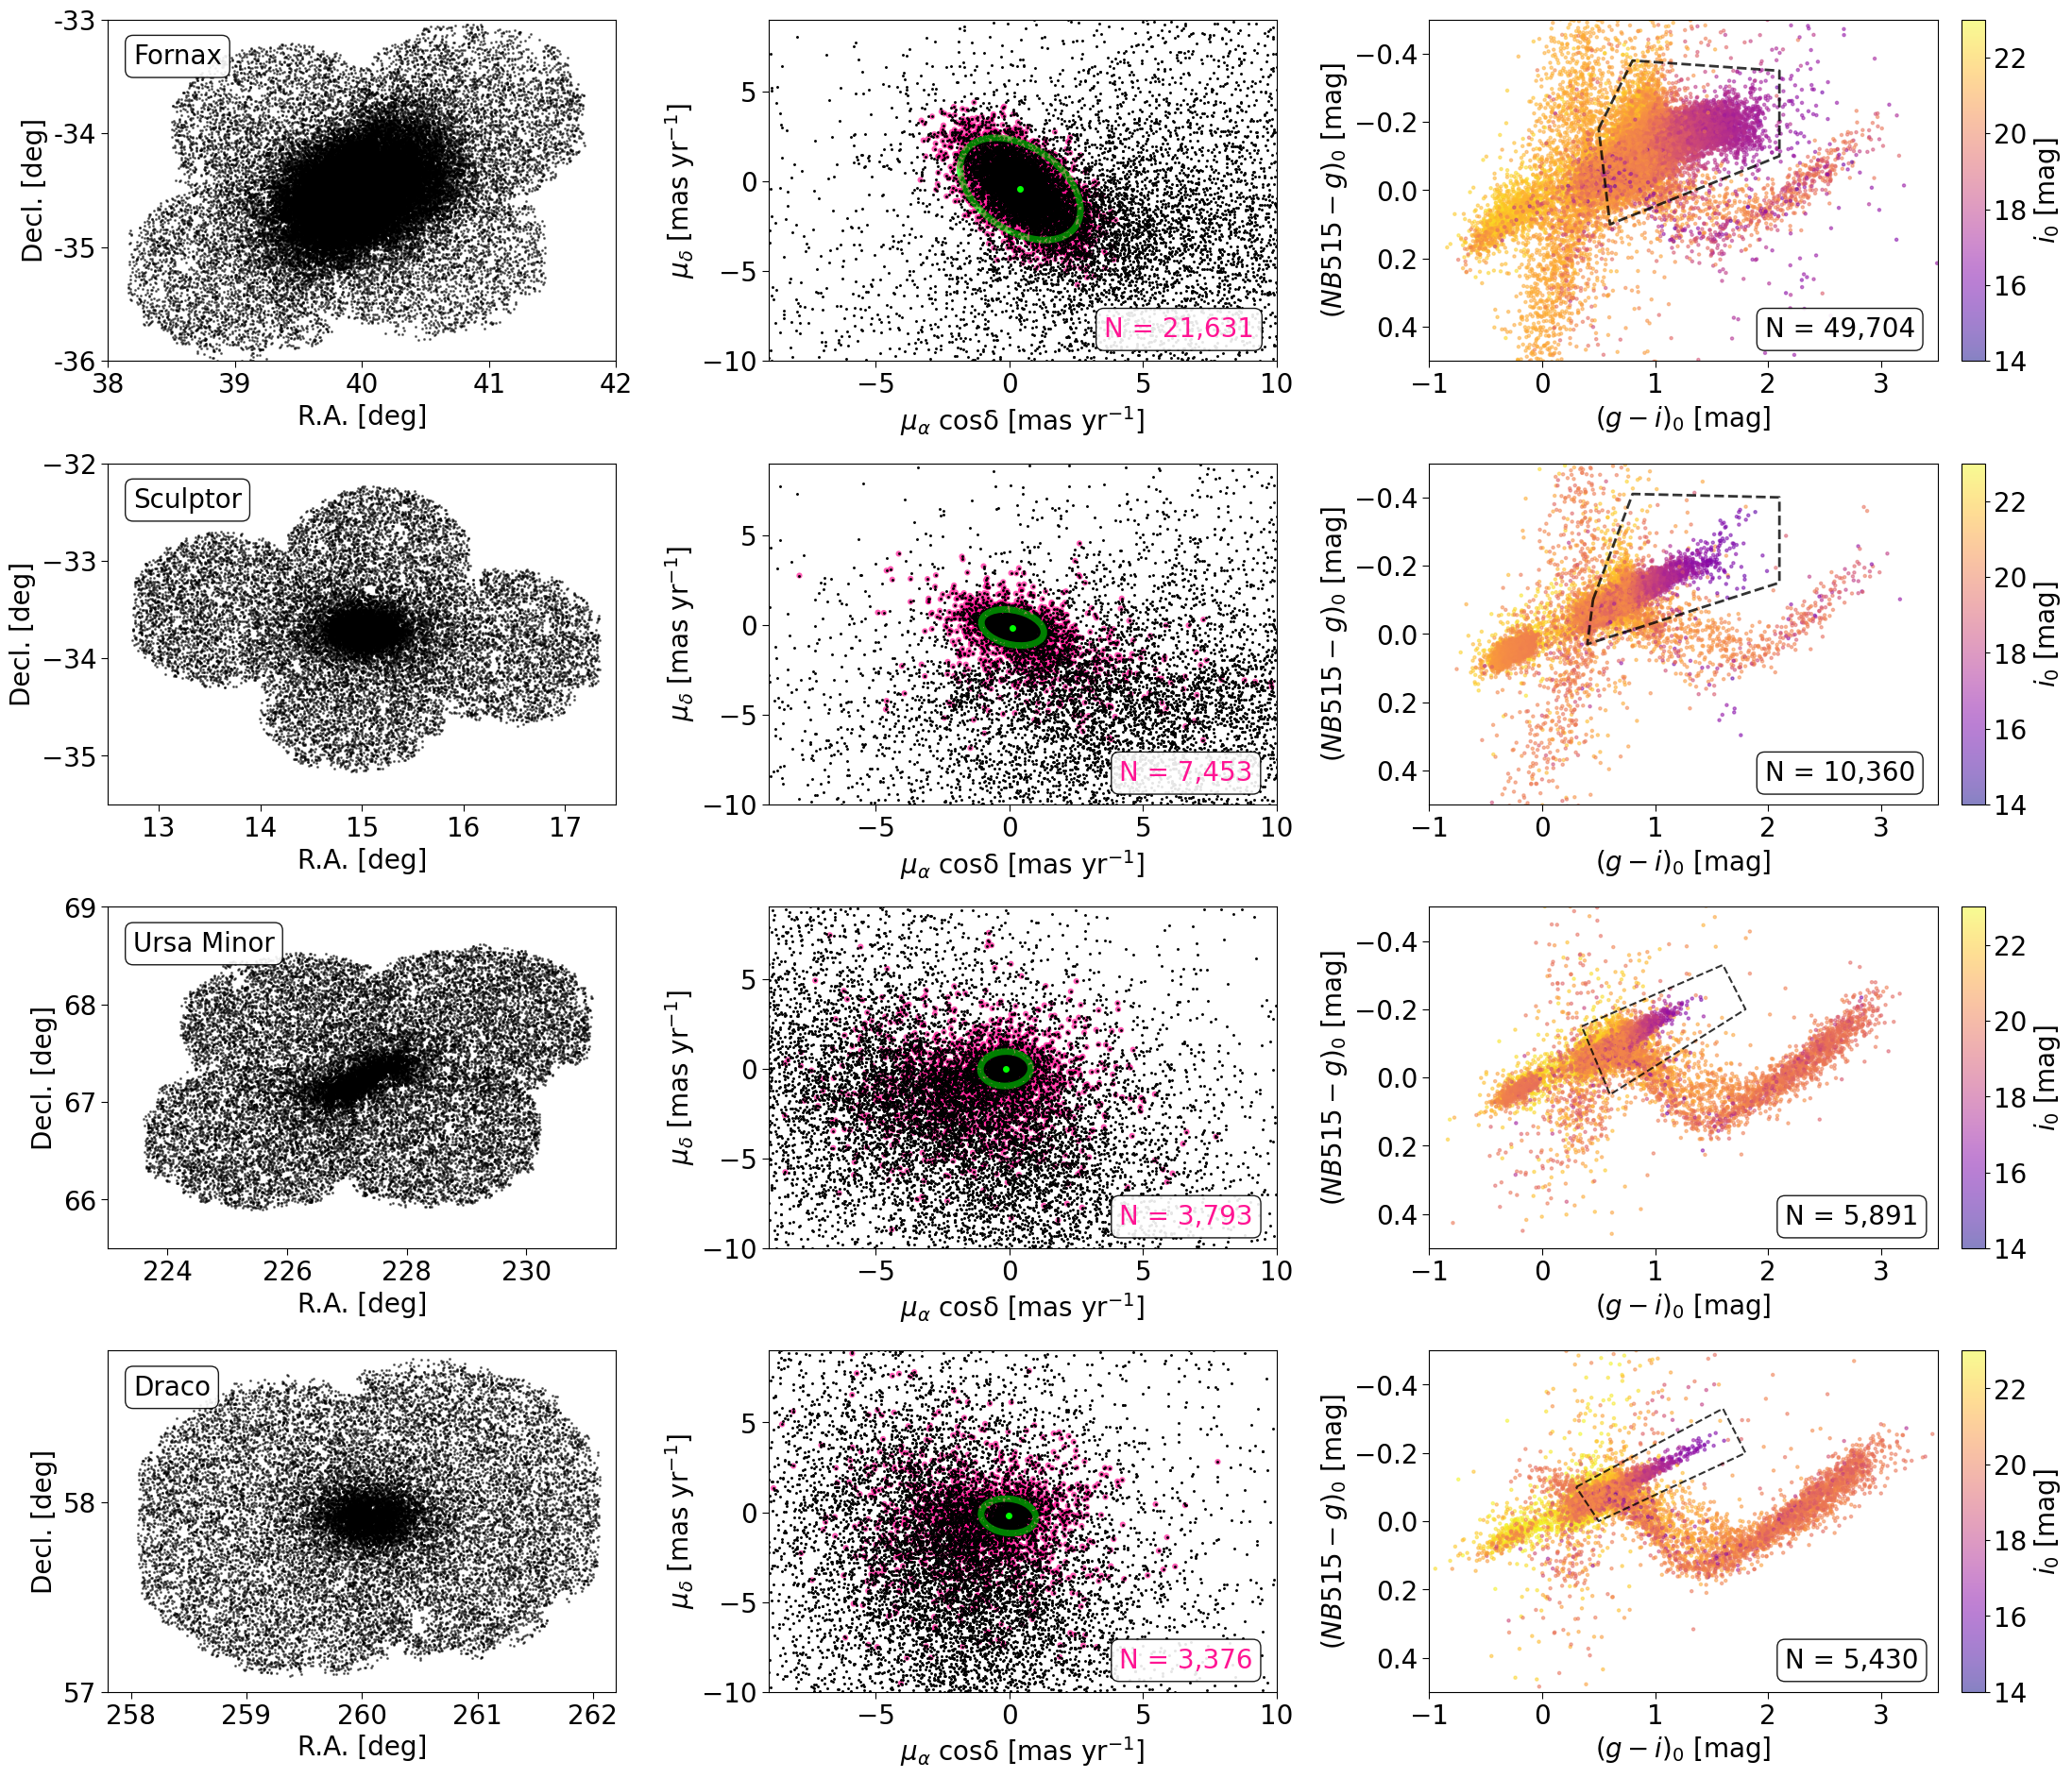

In [45]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(25, 23), gridspec_kw={'hspace':0.3, 'wspace':0.3})
alpha = .5 ; s = 5

axs[0,0].scatter(hsc_df1_gaia_sc_magerr['ra'], hsc_df1_gaia_sc_magerr['dec'], marker='.', s=s, color='k', alpha=.5)
axs[0,0].set_xlabel('R.A. [deg]', size=20)
axs[0,0].set_ylabel('Decl. [deg]', size=20)
axs[0,0].set_xlim([38, 42])
axs[0,0].set_ylim([-36, -33])
axs[0,0].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[0,0].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
axs[0,0].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[0,0].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
axs[0,0].set_yticks([-36, -35, -34, -33])
axs[0,0].set_yticklabels(np.arange(-36, -32, 1))
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[0,0].text(0.05, 0.87, 'Fornax', transform=axs[0,0].transAxes, fontsize=20, color='k', bbox=props)

pmRA = hsc_df1_gaia_sc_magerr_availpm['pmRA']
pmDE = hsc_df1_gaia_sc_magerr_availpm['pmDE']
err_pmra = hsc_df1_gaia_sc_magerr_availpm['e_pmRA']
err_pmdec = hsc_df1_gaia_sc_magerr_availpm['e_pmDE']
err_pm = np.sqrt(err_pmra**2 + err_pmdec**2)
# Sigma Clipping
clipped_pmRA = sigma_clip(pmRA, sigma=3, maxiters=10, stdfunc=np.std)
clipped_pmDE = sigma_clip(pmDE, sigma=3, maxiters=10, stdfunc=np.std)
mean_pmRA = np.round(np.mean(clipped_pmRA), 3)
mean_pmDE = np.round(np.mean(clipped_pmDE), 3)
std_pmRA = np.round(np.std(clipped_pmRA), 3)
std_pmDE = np.round(np.std(clipped_pmDE), 3)
print('clipped mean pmRA pmDE =', mean_pmRA, mean_pmDE) #0.411 -0.426
print('clipped std pmRA pmDE =', std_pmRA, std_pmDE) #0.628 1.033
pmra_0, pmdec_0 = mean_pmRA, mean_pmDE
r_a, r_b = np.round(std_pmRA * 3, 3), np.round(std_pmDE * 3, 3)
print('r_a, r_b =', r_a, r_b) #1.884 3.099
axs[0,1].plot(pmra_0, pmdec_0, marker='o', markersize=4, color='lime')
ellipse = Ellipse(xy=[pmra_0, pmdec_0], width=r_a*2, height=r_b*2, angle=30, edgecolor='lime', fc='None', lw=5, alpha=0.5)
axs[0,1].add_patch(ellipse)
angle = ellipse.angle
def within_ellipse(x, y, x_0, y_0, r_a, r_b):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2
def within_ellipse_w_errpm(x, y, x_0, y_0, r_a, r_b, err_pm):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2 + (3 * err_pm)**2
theta = np.radians(360 - angle)
mask = hsc_df1_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse_w_errpm(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b, np.sqrt(row['e_pmRA']**2 + row['e_pmDE']**2)), axis=1)
filtered_hsc_df1_gaia_sc_magerr_availpm = hsc_df1_gaia_sc_magerr_availpm[mask]
print('len(filtered data) =', len(filtered_hsc_df1_gaia_sc_magerr_availpm)) #21631
axs[0,1].scatter(filtered_hsc_df1_gaia_sc_magerr_availpm['pmRA'], filtered_hsc_df1_gaia_sc_magerr_availpm['pmDE'], marker='o', s=20, facecolor='deeppink', edgecolor='none', alpha=0.7)
axs[0,1].scatter(hsc_df1_gaia_sc_magerr['pmRA'], hsc_df1_gaia_sc_magerr['pmDE'], marker='.', s=s, color='k', alpha=1)
axs[0,1].add_patch(ellipse)
axs[0,1].set_xlabel('$\mu_{\\alpha}~\mathrm{cos\delta}$ [mas yr$^{-1}$]', size=20)
axs[0,1].set_ylabel('$\mu_{\delta}$ [mas yr$^{-1}$]', size=20)
axs[0,1].set_xlim([-9, 10])
axs[0,1].set_ylim([-10, 9])
axs[0,1].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[0,1].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
axs[0,1].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[0,1].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[0,1].text(0.66, 0.07, 'N = {0:,.0f}'.format(len(filtered_hsc_df1_gaia_sc_magerr_availpm)), transform=axs[0,1].transAxes, fontsize=20, color='deeppink', bbox=props)
mask_test = hsc_df1_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b), axis=1)
inside_ellipse_test = hsc_df1_gaia_sc_magerr_availpm[mask_test]
print('len(inside the ellipse) =', len(inside_ellipse_test)) #20976
filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm = pd.concat([hsc_df1_gaia_sc_magerr_nonpm, filtered_hsc_df1_gaia_sc_magerr_availpm], axis=0)
print('len(filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm) =', len(filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm)) #57651

img = axs[0,2].scatter(filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['g0'] - filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['i0'], filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['n0'] - filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['g0'], 
                     marker='o', s=s, c=filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['i0'], cmap='plasma', alpha=alpha)
axs[0,2].set_xlim([-1, 3.5])
axs[0,2].set_ylim([0.5, -0.5])
axs[0,2].set_xlabel('$(g - i)_{0}$ [mag]', size=20)
axs[0,2].set_ylabel('$(NB515 - g)_{0}$ [mag]', size=20)
axs[0,2].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[0,2].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
axs[0,2].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[0,2].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
cax = fig.add_axes([axs[0,2].get_position().x1+0.01, axs[0,2].get_position().y0, 0.01, axs[0,2].get_position().height])
cbar = plt.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('$i_{0}$ [mag]', size=20)
cbar.mappable.set_clim(vmin=14, vmax=23)
cbar.update_ticks()
coord = [[0.5, -0.18], [0.8, -0.38], [2.1, -0.35], [2.1, -0.1], [0.6, 0.1], [0.5, -0.18]]
xs, ys = zip(*coord)
axs[0,2].plot(xs, ys, linestyle='--', linewidth=2, alpha=.8, color='k')
polygon = Path(coord)
points = np.vstack((filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['g0'] - filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['i0'], filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['n0'] - filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm['g0'])).T
inside = polygon.contains_points(points)
hsc_df1_gaia_sc_magerr_availpm_inside_polygon = filtered_hsc_df1_gaia_sc_magerr_availpm_nonpm[inside]
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[0,2].text(0.66, 0.07, 'N = {0:,.0f}'.format(len(hsc_df1_gaia_sc_magerr_availpm_inside_polygon)), transform=axs[0,2].transAxes, fontsize=20, color='black', bbox=props)
print('len(hsc_df1_gaia_sc_magerr_availpm_inside_polygon) =', len(hsc_df1_gaia_sc_magerr_availpm_inside_polygon)) #23089



axs[1,0].scatter(hsc_df2_gaia_sc_magerr['ra'], hsc_df2_gaia_sc_magerr['dec'], marker='.', s=s, color='k', alpha=.5)
axs[1,0].set_xlabel('R.A. [deg]', size=20)
axs[1,0].set_ylabel('Decl. [deg]', size=20)
axs[1,0].set_xlim([12.5, 17.5])
axs[1,0].set_ylim([-35.5, -32])
axs[1,0].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[1,0].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
axs[1,0].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[1,0].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
axs[1,0].text(0.05, 0.87, 'Sculptor', transform=axs[1,0].transAxes, fontsize=20, color='k', bbox=props)

pmRA = hsc_df2_gaia_sc_magerr_availpm['pmRA']
pmDE = hsc_df2_gaia_sc_magerr_availpm['pmDE']
err_pmra = hsc_df2_gaia_sc_magerr_availpm['e_pmRA']
err_pmdec = hsc_df2_gaia_sc_magerr_availpm['e_pmDE']
err_pm = np.sqrt(err_pmra**2 + err_pmdec**2)
# Sigma Clipping
clipped_pmRA = sigma_clip(pmRA, sigma=2, maxiters=10, stdfunc=np.std)
clipped_pmDE = sigma_clip(pmDE, sigma=2, maxiters=10, stdfunc=np.std)
mean_pmRA = np.round(np.mean(clipped_pmRA), 3)
mean_pmDE = np.round(np.mean(clipped_pmDE), 3)
std_pmRA = np.round(np.std(clipped_pmRA), 3)
std_pmDE = np.round(np.std(clipped_pmDE), 3)
print('clipped mean pmRA pmDE =', mean_pmRA, mean_pmDE) #0.126 -0.144
print('clipped std pmRA pmDE =', std_pmRA, std_pmDE) #0.415 0.303
pmra_0, pmdec_0 = mean_pmRA, mean_pmDE
r_a, r_b = np.round(std_pmRA * 3, 3), np.round(std_pmDE * 3, 3)
print('r_a, r_b =', r_a, r_b) #1.245 0.909
axs[1,1].plot(pmra_0, pmdec_0, marker='o', markersize=4, color='lime')
ellipse = Ellipse(xy=[pmra_0, pmdec_0], width=r_a*2, height=r_b*2, angle=150, edgecolor='lime', fc='None', lw=5, alpha=0.5)
axs[1,1].add_patch(ellipse)
angle = ellipse.angle
def within_ellipse(x, y, x_0, y_0, r_a, r_b):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2
def within_ellipse_w_errpm(x, y, x_0, y_0, r_a, r_b, err_pm):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2 + (3 * err_pm)**2
theta = np.radians(360 - angle)
mask = hsc_df2_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse_w_errpm(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b, np.sqrt(row['e_pmRA']**2 + row['e_pmDE']**2)), axis=1)
filtered_hsc_df2_gaia_sc_magerr_availpm = hsc_df2_gaia_sc_magerr_availpm[mask]
print('len(filtered data) =', len(filtered_hsc_df2_gaia_sc_magerr_availpm)) #7453
axs[1,1].scatter(filtered_hsc_df2_gaia_sc_magerr_availpm['pmRA'], filtered_hsc_df2_gaia_sc_magerr_availpm['pmDE'], marker='o', s=20, facecolor='deeppink', edgecolor='none', alpha=0.7)
axs[1,1].scatter(hsc_df2_gaia_sc_magerr['pmRA'], hsc_df2_gaia_sc_magerr['pmDE'], marker='.', s=s, color='k', alpha=1)
axs[1,1].add_patch(ellipse)
axs[1,1].set_xlabel('$\mu_{\\alpha}~\mathrm{cos\delta}$ [mas yr$^{-1}$]', size=20)
axs[1,1].set_ylabel('$\mu_{\delta}$ [mas yr$^{-1}$]', size=20)
axs[1,1].set_xlim([-9, 10])
axs[1,1].set_ylim([-10, 9])
axs[1,1].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[1,1].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
axs[1,1].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[1,1].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[1,1].text(0.69, 0.07, 'N = {0:,.0f}'.format(len(filtered_hsc_df2_gaia_sc_magerr_availpm)), transform=axs[1,1].transAxes, fontsize=20, color='deeppink', bbox=props)
mask_test = hsc_df2_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b), axis=1)
inside_ellipse_test = hsc_df2_gaia_sc_magerr_availpm[mask_test]
print('len(inside the ellipse) =', len(inside_ellipse_test)) #6263
filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm = pd.concat([hsc_df2_gaia_sc_magerr_nonpm, filtered_hsc_df2_gaia_sc_magerr_availpm], axis=0)
print('len(filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm) =', len(filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm)) #14325

img = axs[1,2].scatter(filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['g0'] - filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['i0'], filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['n0'] - filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['g0'], 
                     marker='o', s=s, c=filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['i0'], cmap='plasma', alpha=alpha)
axs[1,2].set_xlim([-1, 3.5])
axs[1,2].set_ylim([0.5, -0.5])
axs[1,2].set_xlabel('$(g - i)_{0}$ [mag]', size=20)
axs[1,2].set_ylabel('$(NB515 - g)_{0}$ [mag]', size=20)
axs[1,2].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[1,2].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
axs[1,2].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[1,2].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
cax = fig.add_axes([axs[1,2].get_position().x1+0.01, axs[1,2].get_position().y0, 0.01, axs[1,2].get_position().height])
cbar = plt.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('$i_{0}$ [mag]', size=20)
cbar.mappable.set_clim(vmin=14, vmax=23)
cbar.update_ticks()
coord = [[0.45, -0.1], [0.8, -0.41], [2.1, -0.4], [2.1, -0.15], [0.4, 0.03], [0.45, -0.1]]
xs, ys = zip(*coord)
axs[1,2].plot(xs, ys, linestyle='--', linewidth=2, alpha=.8, color='k')
polygon = Path(coord)
points = np.vstack((filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['g0'] - filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['i0'], filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['n0'] - filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm['g0'])).T
inside = polygon.contains_points(points)
hsc_df2_gaia_sc_magerr_availpm_inside_polygon = filtered_hsc_df2_gaia_sc_magerr_availpm_nonpm[inside]
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[1,2].text(0.66, 0.07, 'N = {0:,.0f}'.format(len(hsc_df2_gaia_sc_magerr_availpm_inside_polygon)), transform=axs[1,2].transAxes, fontsize=20, color='black', bbox=props)
print('len(hsc_df2_gaia_sc_magerr_availpm_inside_polygon) =', len(hsc_df2_gaia_sc_magerr_availpm_inside_polygon)) #2137



axs[2,0].scatter(hsc_df3_gaia_sc_magerr['ra'], hsc_df3_gaia_sc_magerr['dec'], marker='.', s=s, color='k', alpha=.5)
axs[2,0].set_xlabel('R.A. [deg]', size=20)
axs[2,0].set_ylabel('Decl. [deg]', size=20)
axs[2,0].set_xlim([223, 231.5])
axs[2,0].set_ylim([65.5, 69])
axs[2,0].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[2,0].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
axs[2,0].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[2,0].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
axs[2,0].text(0.05, 0.87, 'Ursa Minor', transform=axs[2,0].transAxes, fontsize=20, color='k', bbox=props)

pmRA = hsc_df3_gaia_sc_magerr_availpm['pmRA']
pmDE = hsc_df3_gaia_sc_magerr_availpm['pmDE']
err_pmra = hsc_df3_gaia_sc_magerr_availpm['e_pmRA']
err_pmdec = hsc_df3_gaia_sc_magerr_availpm['e_pmDE']
err_pm = np.sqrt(err_pmra**2 + err_pmdec**2)
# Sigma Clipping
clipped_pmRA = sigma_clip(pmRA, sigma=1.5, maxiters=10, stdfunc=np.std)
clipped_pmDE = sigma_clip(pmDE, sigma=1.5, maxiters=10, stdfunc=np.std)
mean_pmRA = np.round(np.mean(clipped_pmRA), 3)
mean_pmDE = np.round(np.mean(clipped_pmDE), 3)
std_pmRA = np.round(np.std(clipped_pmRA), 3)
std_pmDE = np.round(np.std(clipped_pmDE), 3)
print('clipped mean pmRA pmDE =', mean_pmRA, mean_pmDE) #-0.139 -0.013
print('clipped std pmRA pmDE =', std_pmRA, std_pmDE) #0.311 0.322
pmra_0, pmdec_0 = mean_pmRA, mean_pmDE
r_a, r_b = np.round(std_pmRA * 3, 3), np.round(std_pmDE * 3, 3)
print('r_a, r_b =', r_a, r_b) #0.933 0.966
axs[2,1].plot(pmra_0, pmdec_0, marker='o', markersize=4, color='lime')
ellipse = Ellipse(xy=[pmra_0, pmdec_0], width=r_a*2, height=r_b*2, angle=150, edgecolor='lime', fc='None', lw=5, alpha=0.5)
axs[2,1].add_patch(ellipse)
angle = ellipse.angle
def within_ellipse(x, y, x_0, y_0, r_a, r_b):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2
def within_ellipse_w_errpm(x, y, x_0, y_0, r_a, r_b, err_pm):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2 + (3 * err_pm)**2
theta = np.radians(360 - angle)
mask = hsc_df3_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse_w_errpm(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b, np.sqrt(row['e_pmRA']**2 + row['e_pmDE']**2)), axis=1)
filtered_hsc_df3_gaia_sc_magerr_availpm = hsc_df3_gaia_sc_magerr_availpm[mask]
print('len(filtered data) =', len(filtered_hsc_df3_gaia_sc_magerr_availpm)) #3793
axs[2,1].scatter(filtered_hsc_df3_gaia_sc_magerr_availpm['pmRA'], filtered_hsc_df3_gaia_sc_magerr_availpm['pmDE'], marker='o', s=20, facecolor='deeppink', edgecolor='none', alpha=0.7)
axs[2,1].scatter(hsc_df3_gaia_sc_magerr['pmRA'], hsc_df3_gaia_sc_magerr['pmDE'], marker='.', s=s, color='k', alpha=1)
axs[2,1].add_patch(ellipse)
axs[2,1].set_xlabel('$\mu_{\\alpha}~\mathrm{cos\delta}$ [mas yr$^{-1}$]', size=20)
axs[2,1].set_ylabel('$\mu_{\delta}$ [mas yr$^{-1}$]', size=20)
axs[2,1].set_xlim([-9, 10])
axs[2,1].set_ylim([-10, 9])
axs[2,1].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[2,1].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
axs[2,1].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[2,1].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[2,1].text(0.69, 0.07, 'N = {0:,.0f}'.format(len(filtered_hsc_df3_gaia_sc_magerr_availpm)), transform=axs[2,1].transAxes, fontsize=20, color='deeppink', bbox=props)
mask_test = hsc_df3_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b), axis=1)
inside_ellipse_test = hsc_df3_gaia_sc_magerr_availpm[mask_test]
print('len(inside the ellipse) =', len(inside_ellipse_test)) #1952
filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm = pd.concat([hsc_df3_gaia_sc_magerr_nonpm, filtered_hsc_df3_gaia_sc_magerr_availpm], axis=0)
print('len(filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm) =', len(filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm)) #11132

img = axs[2,2].scatter(filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['g0'] - filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['i0'], filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['n0'] - filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['g0'], 
                     marker='o', s=s, c=filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['i0'], cmap='plasma', alpha=alpha)
axs[2,2].set_xlim([-1, 3.5])
axs[2,2].set_ylim([0.5, -0.5])
axs[2,2].set_xlabel('$(g - i)_{0}$ [mag]', size=20)
axs[2,2].set_ylabel('$(NB515 - g)_{0}$ [mag]', size=20)
axs[2,2].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[2,2].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
axs[2,2].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[2,2].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
cax = fig.add_axes([axs[2,2].get_position().x1+0.01, axs[2,2].get_position().y0, 0.01, axs[2,2].get_position().height])
cbar = plt.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('$i_{0}$ [mag]', size=20)
cbar.mappable.set_clim(vmin=14, vmax=23)
cbar.update_ticks()
coord = [[0.35, -0.15], [1.6, -0.33], [1.8, -0.2], [0.6, 0.05], [0.35, -0.15]]
xs, ys = zip(*coord)
axs[2,2].plot(xs, ys, linestyle='--', linewidth=1.5, alpha=.8, color='k')
polygon = Path(coord)
points = np.vstack((filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['g0'] - filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['i0'], filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['n0'] - filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm['g0'])).T
inside = polygon.contains_points(points)
hsc_df3_gaia_sc_magerr_availpm_inside_polygon = filtered_hsc_df3_gaia_sc_magerr_availpm_nonpm[inside]
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[2,2].text(0.7, 0.07, 'N = {0:,.0f}'.format(len(hsc_df3_gaia_sc_magerr_availpm_inside_polygon)), transform=axs[2,2].transAxes, fontsize=20, color='black', bbox=props)
print('len(hsc_df3_gaia_sc_magerr_availpm_inside_polygon) =', len(hsc_df3_gaia_sc_magerr_availpm_inside_polygon)) #921



axs[3,0].scatter(hsc_df4_gaia_sc_magerr['ra'], hsc_df4_gaia_sc_magerr['dec'], marker='.', s=s, color='k', alpha=.5)
axs[3,0].set_xlabel('R.A. [deg]', size=20)
axs[3,0].set_ylabel('Decl. [deg]', size=20)
axs[3,0].set_xlim([257.8, 262.2])
axs[3,0].set_ylim([57, 58.8])
axs[3,0].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[3,0].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
axs[3,0].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[3,0].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
axs[3,0].set_yticks([58, 57])
axs[3,0].set_yticklabels(np.arange(58, 56, -1))
axs[3,0].text(0.05, 0.87, 'Draco', transform=axs[3,0].transAxes, fontsize=20, color='k', bbox=props)

pmRA = hsc_df4_gaia_sc_magerr_availpm['pmRA']
pmDE = hsc_df4_gaia_sc_magerr_availpm['pmDE']
err_pmra = hsc_df4_gaia_sc_magerr_availpm['e_pmRA']
err_pmdec = hsc_df4_gaia_sc_magerr_availpm['e_pmDE']
err_pm = np.sqrt(err_pmra**2 + err_pmdec**2)
# Sigma Clipping
clipped_pmRA = sigma_clip(pmRA, sigma=1.5, maxiters=10, stdfunc=np.std)
clipped_pmDE = sigma_clip(pmDE, sigma=1.5, maxiters=10, stdfunc=np.std)
mean_pmRA = np.round(np.mean(clipped_pmRA), 3)
mean_pmDE = np.round(np.mean(clipped_pmDE), 3)
std_pmRA = np.round(np.std(clipped_pmRA), 3)
std_pmDE = np.round(np.std(clipped_pmDE), 3)
print('clipped mean pmRA pmDE =', mean_pmRA, mean_pmDE) # -0.033 -0.206
print('clipped std pmRA pmDE =', std_pmRA, std_pmDE) #0.351 0.31
pmra_0, pmdec_0 = mean_pmRA, mean_pmDE
r_a, r_b = np.round(std_pmRA * 3, 3), np.round(std_pmDE * 3, 3)
print('r_a, r_b =', r_a, r_b) #1.053 0.930
axs[3,1].plot(pmra_0, pmdec_0, marker='o', markersize=4, color='lime')
ellipse = Ellipse(xy=[pmra_0, pmdec_0], width=r_a*2, height=r_b*2, angle=150, edgecolor='lime', fc='None', lw=5, alpha=0.5)
axs[3,1].add_patch(ellipse)
angle = ellipse.angle
def within_ellipse(x, y, x_0, y_0, r_a, r_b):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2
def within_ellipse_w_errpm(x, y, x_0, y_0, r_a, r_b, err_pm):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2 + (3 * err_pm)**2
theta = np.radians(360 - angle)
mask = hsc_df4_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse_w_errpm(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b, np.sqrt(row['e_pmRA']**2 + row['e_pmDE']**2)), axis=1)
filtered_hsc_df4_gaia_sc_magerr_availpm = hsc_df4_gaia_sc_magerr_availpm[mask]
print('len(filtered data) =', len(filtered_hsc_df4_gaia_sc_magerr_availpm)) #3376
axs[3,1].scatter(filtered_hsc_df4_gaia_sc_magerr_availpm['pmRA'], filtered_hsc_df4_gaia_sc_magerr_availpm['pmDE'], marker='o', s=20, facecolor='deeppink', edgecolor='none', alpha=0.7)
axs[3,1].scatter(hsc_df4_gaia_sc_magerr['pmRA'], hsc_df4_gaia_sc_magerr['pmDE'], marker='.', s=s, color='k', alpha=1)
axs[3,1].add_patch(ellipse)
axs[3,1].set_xlabel('$\mu_{\\alpha}~\mathrm{cos\delta}$ [mas yr$^{-1}$]', size=20)
axs[3,1].set_ylabel('$\mu_{\delta}$ [mas yr$^{-1}$]', size=20)
axs[3,1].set_xlim([-9, 10])
axs[3,1].set_ylim([-10, 9])
axs[3,1].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[3,1].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
axs[3,1].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[3,1].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[3,1].text(0.69, 0.07, 'N = {0:,.0f}'.format(len(filtered_hsc_df4_gaia_sc_magerr_availpm)), transform=axs[3,1].transAxes, fontsize=20, color='deeppink', bbox=props)
mask_test = hsc_df4_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b), axis=1)
inside_ellipse_test = hsc_df4_gaia_sc_magerr_availpm[mask_test]
print('len(inside the ellipse) =', len(inside_ellipse_test)) #1715
filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm = pd.concat([hsc_df4_gaia_sc_magerr_nonpm, filtered_hsc_df4_gaia_sc_magerr_availpm], axis=0)
print('len(filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm) =', len(filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm)) #11526

img = axs[3,2].scatter(filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['g0'] - filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['i0'], filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['n0'] - filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['g0'], 
                     marker='o', s=s, c=filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['i0'], cmap='plasma', alpha=alpha)
axs[3,2].set_xlim([-1, 3.5])
axs[3,2].set_ylim([0.5, -0.5])
axs[3,2].set_xlabel('$(g - i)_{0}$ [mag]', size=20)
axs[3,2].set_ylabel('$(NB515 - g)_{0}$ [mag]', size=20)
axs[3,2].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[3,2].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
axs[3,2].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=20)
axs[3,2].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=20)
cax = fig.add_axes([axs[3,2].get_position().x1+0.01, axs[3,2].get_position().y0, 0.01, axs[3,2].get_position().height])
cbar = plt.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('$i_{0}$ [mag]', size=20)
cbar.mappable.set_clim(vmin=14, vmax=23)
cbar.update_ticks()
coord = [[0.3, -0.1], [1.6, -0.33], [1.8, -0.2], [0.5, 0], [0.3, -0.1]]
xs, ys = zip(*coord)
axs[3,2].plot(xs, ys, linestyle='--', linewidth=1.5, alpha=.8, color='k')
polygon = Path(coord)
points = np.vstack((filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['g0'] - filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['i0'], filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['n0'] - filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm['g0'])).T
inside = polygon.contains_points(points)
hsc_df4_gaia_sc_magerr_availpm_inside_polygon = filtered_hsc_df4_gaia_sc_magerr_availpm_nonpm[inside]
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[3,2].text(0.7, 0.07, 'N = {0:,.0f}'.format(len(hsc_df4_gaia_sc_magerr_availpm_inside_polygon)), transform=axs[3,2].transAxes, fontsize=20, color='black', bbox=props)
print('len(hsc_df4_gaia_sc_magerr_availpm_inside_polygon) =', len(hsc_df4_gaia_sc_magerr_availpm_inside_polygon)) #740


plt.savefig('ccd_select_sample_Fornax_Sculptor_Ursaminor_Draco_pm.png', bbox_inches='tight')